# Table of Contents
1. [Data Collection](#data_collection)
2. [Data Discovery](#data_discovery)
3. [Hero DataFrame](#hero_df)
4. [Match DataFrame](#match_df)
5. [Player DataFrame](#player_df)
6. [Merging DataFrames](#merging)
7. [Searching for Heuristics and Correlations](#analysis)
8. [Clustering Team Compositions](#clustering)
9. [Refactoring Training Data](#refactoring)
10. [Outcome Prediction](#prediction)
11. [Conclusion](#conclusion)

# 1. Data Collection <a name="data_collection"></a>
The data collection isn't done through this notebook since it can be very lengthy so it is done in a separate script. The collection is long because it is achieved by scrapping web pages and making calls to an API. Both of these methods require some sort of timeout in between calls so that the server doesn't block our requests. Furthermore, the API used by the python code isn't supported by Anaconda. To collect the data set you must perform the following operations:  
1. pip3 install -t ../dota2/requirements.txt
2. python3 ../dota2/src/api_wrapper.py  

The dataset will be saved in *../dota2/src/data/*  

## 1.1 Downloaded Files   
**Running the script above will gather recent data from the DOTA 2 servers:**  
[dota2api](http://dota2api.readthedocs.io/en/latest/index.html)
* match.json
* heroes.json
* items.json

[DOTABUFF](https://www.dotabuff.com/heroes/played)
* hero_monthly_stats.json
* player_stats.json

---

**Here are the static files that come with the repository:**  
[Liquipedia](https://liquipedia.net/dota2/Hero_Roles)
* hero_complexity.txt
* hero_role.txt

[dota2lists](http://dota2lists.blogspot.com/2014/06/dota-2-hero-abbreviations.html)
* hero_abbreviations.txt  

# 2 Data Discovery  <a name="data_discovery"></a>
First and foremost, I am an experienced DOTA player which allows me to analyze the data easily and efficiently. In other words, where a novice would require professional help for analysis, I can achieve the same results on my own.   

The main data used in this research is the **match.json** file which is already well defined in a .json format. The **heroes.json** and **items.json** will compliment the former file through foreign keys. Finally, all other ressources will be used to enrich this information.  

It is not clear as of yet which information is relevant or irrelevant for the scope of this research so naturally the first step is to analyze each file individually.  

*Please note that the 3 original files I started with were **match.json**, **heroes.json**, and **items.json**. The other files were added as I saw fit throughout the lifecycle of this process.*

## 2.1 Analyzing match.json  

The **match.json** file is the main one to work with, so we start by inspecting this one.

In [1]:
import json
import pandas as pd

# load match data
with open('data/match.json') as f:
    raw_match_data = json.load(f)

# display table head
match_df = pd.DataFrame(raw_match_data).transpose()
match_df.head()

,barracks_status_dire,barracks_status_radiant,cluster,cluster_name,dire_captain,dire_logo,dire_name,dire_score,dire_team_complete,dire_team_id,...,radiant_captain,radiant_logo,radiant_name,radiant_score,radiant_team_complete,radiant_team_id,radiant_win,start_time,tower_status_dire,tower_status_radiant
3933443171,51,63,123,US East,NaN,NaN,NaN,33,NaN,NaN,...,NaN,NaN,NaN,44,NaN,NaN,True,1528134586,256,1846
3933443172,0,63,131,Europe West,NaN,NaN,NaN,34,NaN,NaN,...,NaN,NaN,NaN,49,NaN,NaN,True,1528134586,0,1983
3933443173,0,63,123,US East,NaN,NaN,NaN,40,NaN,NaN,...,NaN,NaN,NaN,68,NaN,NaN,True,1528134574,0,1844
3933443174,63,0,232,NaN,NaN,NaN,NaN,43,NaN,NaN,...,NaN,NaN,NaN,30,NaN,NaN,False,1528134585,1975,0
3933443175,0,63,155,Southeast Asia,NaN,NaN,NaN,31,NaN,NaN,...,NaN,NaN,NaN,54,NaN,NaN,True,1528134587,0,1974


Some columns are hidden due to their abbundance so we can simply print their headers.

In [2]:
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_logo', 'dire_name', 'dire_score',
       'dire_team_complete', 'dire_team_id', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_logo', 'radiant_name', 'radiant_score',
       'radiant_team_complete', 'radiant_team_id', 'radiant_win', 'start_time',
       'tower_status_dire', 'tower_status_radiant'],
      dtype='object')

We notice there are 2 columns with dictionaries: **picks_bans** and **players**. We can expand both of their fields to further investigate their contents.  

### 2.1.1  Analyzing the player dictionary
We first investigate the **players** dictionary

In [3]:
index = match_df.index[0]
type(match_df.loc[index]['players'])

list

The player column is a list of players and therefore we will only display the values for the first item in the collection.

In [4]:
match_df.loc[index]['players'][0]

{'ability_upgrades': [{'ability': 5426, 'level': 1, 'time': 185},
  {'ability': 5427, 'level': 2, 'time': 363},
  {'ability': 5427, 'level': 3, 'time': 466},
  {'ability': 5428, 'level': 4, 'time': 624},
  {'ability': 5427, 'level': 5, 'time': 725},
  {'ability': 5429, 'level': 6, 'time': 832},
  {'ability': 5427, 'level': 7, 'time': 942},
  {'ability': 5428, 'level': 8, 'time': 997},
  {'ability': 5428, 'level': 9, 'time': 1154},
  {'ability': 5921, 'level': 10, 'time': 1219},
  {'ability': 5428, 'level': 11, 'time': 1385},
  {'ability': 5429, 'level': 12, 'time': 1430},
  {'ability': 5426, 'level': 13, 'time': 1523},
  {'ability': 5426, 'level': 14, 'time': 1538},
  {'ability': 6145, 'level': 15, 'time': 1623},
  {'ability': 5426, 'level': 16, 'time': 1693},
  {'ability': 5429, 'level': 17, 'time': 1824},
  {'ability': 6133, 'level': 18, 'time': 2100}],
 'account_id': 4294967295,
 'assists': 11,
 'backpack_0': 46,
 'backpack_1': 0,
 'backpack_2': 18,
 'deaths': 4,
 'denies': 10,
 'go

---
From the point of view of someone who has played hundreds of hours of DOTA, I notice that there are 2 types of information present in this column.  
1. A player's performance with a hero --> gold per minute, kills, deaths...
2. a player's choices throughout the game --> item selection, ability upgrades...   

This knowledge is usefull in order to determine what will need to be dropped later on.

### 2.1.1  Analyzing the pick_bans dictionary  

In [5]:
match_df.loc[index]['picks_bans'][0]

{'hero_id': 101, 'is_pick': False, 'order': 0, 'team': 0}

---
As expected, this column isn't too important for our purpose. DOTA offers different game modes, one from which, captains on both teams can choose and ban certain heroes from the draft in a sequential manner instead of a "free-for-all" way. This column is only useful if we investigate that particular game mode which is outside the scope of this research.

## 2.2 Analyzing the items.json
This data was recovered from the API since there are keys from the **match.json** files which points to this. I do not think this will be very important as items are correlated with in-game decisions as opposed to drafting.

In [6]:
# load items.json
with open('data/items.json') as f:
    raw_item_data = json.load(f)
    
item_df = pd.DataFrame(raw_item_data)
item_df.head()

,items,status
0,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
1,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
2,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
3,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200
4,{'url_image': 'http://cdn.dota2.com/apps/dota2...,200


Once again we are confronted with a dictionary inside a column so we can investigate it further.

In [7]:
item_df.loc[0]['items']

{'cost': 2250,
 'id': 1,
 'localized_name': 'Blink Dagger',
 'name': 'item_blink',
 'recipe': 0,
 'secret_shop': 0,
 'side_shop': 1,
 'url_image': 'http://cdn.dota2.com/apps/dota2/images/items/blink_lg.png'}

---
There doesn't seem to be any interesting information in this data. So we can drop the **items.json** altogether.

## 2.3 Analyzing the heroes.json  
I have doubts to how pertinent this information can be since the hero name and id are both present in the **match.json**

In [8]:
# load heroes.json
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
    
hero_df = pd.DataFrame(raw_hero_data)
hero_df.head()

,count,heroes,status
0,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
1,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
2,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
3,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200
4,115,{'url_full_portrait': 'http://cdn.dota2.com/ap...,200


It seems that dota2api likes nested information. We inspect the heroes column further.

In [9]:
hero_df.loc[0]['heroes']

{'id': 1,
 'localized_name': 'Anti-Mage',
 'name': 'npc_dota_hero_antimage',
 'url_full_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_full.png',
 'url_large_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_lg.png',
 'url_small_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_sb.png',
 'url_vertical_portrait': 'http://cdn.dota2.com/apps/dota2/images/heroes/antimage_vert.jpg'}

---
The **id** and **localized_name** fields are interesting but the rest can be dropped. We keep this file in case we want to enrich it.

## 2.4 Analyzing game complexity  
There are many heroes and items available for play in a game and I am afraid that with a limited dataset, the statistics/machine learning will perform poorly. So one interesting metric to look for is the drafting complexity.  

For the sake of curoisity, I have also decided to include the combinations of items in the calculations.  

**What we know:**  
1. 10 heroes are drafted per game and heroes cannot be drafted more than once.
2. 1 hero can hold up to 6 items and items can be purchased multiple times. (we are excluding the hero's stash for this)

In [10]:
import math
item_count = len(raw_item_data['items'])
heroes_count = len(raw_hero_data['heroes'])
heroes_per_game = 10

# hero combinations without repetition
numerator = math.factorial(heroes_count)
denominator = math.factorial(heroes_per_game) * math.factorial(heroes_count - heroes_per_game)
hero_combinations = numerator // denominator

# item combinations with repetition
# A hero can have 0 to 6 items so we calculate the permutations for every number of items
item_combinations = 0
for items_per_hero in range(7):
    numerator = math.factorial(item_count + items_per_hero - 1)
    denominator = math.factorial(item_count - 1) * math.factorial(items_per_hero)
    item_combinations += numerator // denominator

print("Hero Combinations: {}".format(hero_combinations))
print("Item Combinations per Hero: {}".format(item_combinations))

Hero Combinations: 74540394223878
Item Combinations per Hero: 607221379765


---
There is an astonishing **74540394223878** ways of drafting heroes with **607221379765** item combinations for **each** hero drafed! Multiplying these results will tell us how many different drafts and items builds are available.

In [11]:
# Theorycraft combinations
theory_craft_combination = hero_combinations * item_combinations
print('Theory Crafting: {:.2e}'.format(theory_craft_combination))

Theory Crafting: 4.53e+25


---
Finally we find that there are **4.53 * 10^25** theoretical hero setups. This number confirms my suspicions about the performance of a statistical tool which can help us evaluate this problem given that the research is conducted on only a finite set of data points in contrast to the monstrous number obtained. For this reason I have decided to classify the heroes into smaller categories.  

*Also note that heros can level up abilities in a sequential manner which would further increase the complexity stated above. I like to think that this information combined with the different ways of laning and playing would generate a number greater than the one representing the atoms of the universe.*

In [12]:
results = {
    'Combinations': {
        'Heroes': '{:.2e}'.format(hero_combinations),
        'Items': '{:.2e}'.format(item_combinations),
        'Theory Crafting': '{:.2e}'.format(theory_craft_combination)
    }    
}
pd.DataFrame(results)

,Combinations
Heroes,7.45e+13
Items,6.07e+11
Theory Crafting,4.53e+25


## 2.5 Analyzing hero_role.txt
With the numbers of the previous section, I have decided to find information about classifying heroes. In DOTA, every hero can fill multiple roles in a team so we can classify them respectively. Thankfully, the classification has been done by professional players and has been published on the [Liquipedia](https://liquipedia.net/dota2/Hero_Roles) website.  

First step is to look at the format of this information.

In [13]:
# load hero_role.txt
file = open('data/hero_role.txt', 'r')
raw_hero_role_data = ""

# for every line, add it to the empty string
for line in file:
    raw_hero_role_data += line
file.close()

# display only part of the content
print(raw_hero_role_data[:1000])

{| class="wikitable"
!colspan=8| ■■■ Carry
|-
|{{HeroIcon|am}}{{HeroIcon|arc}}{{HeroIcon|ck}}{{HeroIcon|gyro}}{{HeroIcon|medusa}}{{HeroIcon|morph}}{{HeroIcon|naga}}{{HeroIcon|pa}}<br>{{HeroIcon|sniper}}{{HeroIcon|spectre}}{{HeroIcon|tb}}{{HeroIcon|tiny}}{{HeroIcon|troll}}
|-
!colspan=8| ■■ Carry
|-
|{{HeroIcon|alch}}{{HeroIcon|bb}}{{HeroIcon|dk}}{{HeroIcon|huskar}}{{HeroIcon|ls}}{{HeroIcon|lycan}}{{HeroIcon|mk}}{{HeroIcon|slardar}}<br>{{HeroIcon|sven}}{{HeroIcon|wk}}{{HeroIcon|clinkz}}{{HeroIcon|drow}}{{HeroIcon|ember}}{{HeroIcon|void}}{{HeroIcon|jugg}}{{HeroIcon|ld}}<br>{{HeroIcon|luna}}{{HeroIcon|meepo}}{{HeroIcon|pl}}{{HeroIcon|razor}}{{HeroIcon|riki}}{{HeroIcon|sf}}{{HeroIcon|slark}}{{HeroIcon|ta}}<br>{{HeroIcon|ursa}}{{HeroIcon|weaver}}{{HeroIcon|od}}{{HeroIcon|storm}}{{HeroIcon|pangolier}}
|-
!colspan=8| ■ Carry
|-
|{{HeroIcon|abaddon}}{{HeroIcon|brew}}{{HeroIcon|doom}}{{HeroIcon|kunkka}}{{HeroIcon|lc}}{{HeroIcon|ns}}{{HeroIcon|sb}}{{HeroIcon|bs}}<br>{{HeroIcon|brood}}{{HeroIcon|

--- 
The data is unpleasant look at but we notice some level of formatting. According to the wikipedia article the number of '■' represents the difficulty of playing a particular hero for a given role. The name appearing right after the '■' symbol is the class. All items listed under the class are the heroes belonging to it.  

We can then find all the different roles and evaluate whether this classifying approach is feasible and worth the effort.

In [14]:
delimeter_start = "■■■ "
delimeter_end = "\n|-\n|"

# split data through delimeters
delimited_roles = raw_hero_role_data.split(delimeter_start)
roles_list = []

# append hero roles to list
for dr in delimited_roles:
    roles_list.append(dr.split(delimeter_end)[0])
roles_list = roles_list[1:]
print(roles_list)

['Carry', 'Nuker', 'Initiator', 'Disabler', 'Escape', 'Support', 'Pusher', 'Jungler', 'Durable']


---
It looks like there are only 9 roles available which seems correct when comparing to the website's page. This means that the string splitting was successfull. Additionally, 9 roles, where a hero can fulfill more than 1 of them, means that there are 512 role combinations. 
1. Assumption: there will be less than 512 combinations since no heroes can fill all the roles. Subsequently, no heroes can fill none of the roles. Ultimately, we hope that there would be less combinations than the total amount of heroes.
2. A team composition can be represented by an 9 bit integer or a 1 X 9 hotvector.
3. This technique will allow us to represent heroes by their numerical representations which will be useful later on with the machine learning.  

Points #2, and #3 are convincing enough to follow through this technique even if we eventually conclude that #1 won't hold true.

## 2.6 Analyzing hero complexity  
The complexity shares the same format as the **hero_role.text** file. 

In [15]:
# load hero_complexity.txt
file = open('data/hero_complexity.txt')
raw_hero_complexity_data = ""
for line in file:
    raw_hero_complexity_data += line
file.close()
print(raw_hero_complexity_data[500:1000])

y styles.

{| class="wikitable"
!colspan=8| ■■■ Complexity
|-
|{{HeroIcon|brewmaster}}{{HeroIcon|earth spirit}}{{HeroIcon|io}}{{HeroIcon|aw}}{{HeroIcon|ld}}{{HeroIcon|meepo}}{{HeroIcon|morph}}{{HeroIcon|chen}}<br>{{HeroIcon|invoker}}{{HeroIcon|oracle}}{{HeroIcon|rubick}}{{HeroIcon|storm}}{{HeroIcon|visage}}
|-
!colspan=8| ■■ Complexity
|-
|{{HeroIcon|beastmaster}}{{HeroIcon|clock}}{{HeroIcon|doom}}{{HeroIcon|earthshaker}}{{HeroIcon|et}}{{HeroIcon|kunkka}}{{HeroIcon|lifestealer}}{{HeroIcon|lycan}


---
After inspecting this file, I doubt that this data will be any usefull for the research. For instance, a hero can be very hard to play for most players but very easy for few players. For this reason, a hero's complexity will be reflected by a player's win ratio using this character. The win ratio heuristic is a more accurate representation of a hero's complexity than a general classification performed by humans.

## 2.7 Analyzing hero_abbreviations.txt
One key problem I have identified in the previous 2 text files from section 2.5 and 2.6 was that the hero names are non standard. Many of the names listed on the Liquipedia website uses a hero's acronym or nickname used by the DOTA community. Furthermore, a hero has both a name **and** a title which are used interchangeably by users. This information means that we need to standardize the hero names accross the dataset. For this reason, I have collected a dataset which maps all acronyms, titles, names, and nicknames to 1 standard format.

In [16]:
file = open("data/hero_abbreviations.txt", 'r')
sample = ""
for line in file:
    sample += line
file.close()
print(sample[:100])

Abaddon
Alch = Alchemist
AA = Ancient Apparition
AM = Anti-Mage
Arc = Arc Warden
Axe
Bane
Bat = Batr


---
1. Each new line is a new mapping
2. A mapping is shown by '='
3. No presence of '=' means that the name written is the hero's standard one
4. More than 1 mapping can be done per hero

## 2.8 Analyzing player_stats.json 
As mentioned in section 2.6, a player's stats with heroes should represent a more adequate heuristic for their performance. For this reason, I have scrapped [DOTABUFF](https://www.dotabuff.com/players) to obtain stats for players as the API wouldn't provide this functionality.

In [17]:
with open('data/player_stats.json') as f:
    raw_player_stats = json.load(f)

pd.DataFrame(raw_player_stats).transpose().head()

,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Arc Warden,Axe,Bane,Batrider,Beastmaster,Bloodseeker,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Witch Doctor,Wraith King,Zeus
100008925,"{'kda': '1.6428572', 'win_ratio': '50.0', 'gam...","{'kda': '0.94', 'win_ratio': '25.0', 'games_pl...","{'kda': '2.9047618', 'win_ratio': '0.0', 'game...","{'kda': '1.9', 'win_ratio': '50.0', 'games_pla...",NaN,"{'kda': '2.402062', 'win_ratio': '56.0', 'game...","{'kda': '1.625', 'win_ratio': '28.57143', 'gam...","{'kda': '0.90909094', 'win_ratio': '33.333336'...","{'kda': '2.4166667', 'win_ratio': '50.0', 'gam...","{'kda': '1.5966387', 'win_ratio': '38.46154', ...",...,"{'kda': '0.9318182', 'win_ratio': '66.66667', ...","{'kda': '3.490196', 'win_ratio': '52.941177', ...","{'kda': '0.85365856', 'win_ratio': '0.0', 'gam...","{'kda': '1.6142857', 'win_ratio': '40.0', 'gam...","{'kda': '4.1363635', 'win_ratio': '80.0', 'gam...","{'kda': '2.255319', 'win_ratio': '37.5', 'game...",NaN,"{'kda': '1.6140351', 'win_ratio': '45.454548',...","{'kda': '7.4', 'win_ratio': '87.5', 'games_pla...","{'kda': '3.1243522', 'win_ratio': '40.0', 'gam..."
100017039,"{'kda': '2.1860466', 'win_ratio': '66.66667', ...","{'kda': '1.462963', 'win_ratio': '28.57143', '...","{'kda': '2.7595909', 'win_ratio': '53.19149', ...","{'kda': '1.7783641', 'win_ratio': '40.816326',...","{'kda': '1.3333334', 'win_ratio': '33.333336',...","{'kda': '1.9156626', 'win_ratio': '52.63158', ...","{'kda': '1.8333334', 'win_ratio': '100.0', 'ga...","{'kda': '2.3055556', 'win_ratio': '50.0', 'gam...","{'kda': '2.8', 'win_ratio': '100.0', 'games_pl...","{'kda': '2.0159745', 'win_ratio': '51.6129', '...",...,"{'kda': '1.7219917', 'win_ratio': '45.454548',...","{'kda': '2.4564102', 'win_ratio': '35.0', 'gam...","{'kda': '2.8095238', 'win_ratio': '50.0', 'gam...","{'kda': '2.170886', 'win_ratio': '38.88889', '...","{'kda': '3.1704545', 'win_ratio': '47.368423',...","{'kda': '2.2845118', 'win_ratio': '45.714287',...","{'kda': '2.0424528', 'win_ratio': '56.0', 'gam...","{'kda': '1.965642', 'win_ratio': '61.818184', ...","{'kda': '2.2537313', 'win_ratio': '50.0', 'gam...","{'kda': '4.2988505', 'win_ratio': '66.37931', ..."
100048207,"{'kda': '2.8888888', 'win_ratio': '100.0', 'ga...","{'kda': '4.0833335', 'win_ratio': '50.0', 'gam...","{'kda': '8.5', 'win_ratio': '100.0', 'games_pl...","{'kda': '4.7325583', 'win_ratio': '59.090908',...",NaN,"{'kda': '3.0930233', 'win_ratio': '16.666668',...","{'kda': '3.878788', 'win_ratio': '50.0', 'game...","{'kda': '2.3333333', 'win_ratio': '100.0', 'ga...",NaN,"{'kda': '4.629032', 'win_ratio': '72.72727', '...",...,"{'kda': '2.4545455', 'win_ratio': '50.0', 'gam...","{'kda': '4.967742', 'win_ratio': '40.0', 'game...",NaN,NaN,"{'kda': '10.75', 'win_ratio': '100.0', 'games_...","{'kda': '6.5194173', 'win_ratio': '59.615387',...","{'kda': '3.2916667', 'win_ratio': '75.0', 'gam...","{'kda': '3.0769231', 'win_ratio': '100.0', 'ga...","{'kda': '9.846154', 'win_ratio': '60.000004', ...","{'kda': '6.354839', 'win_ratio': '83.33333', '..."
100052152,"{'kda': '2.7674417', 'win_ratio': '53.846157',...","{'kda': '2.2682292', 'win_ratio': '32.0', 'gam...","{'kda': '4.0699706', 'win_ratio': '49.056606',...","{'kda': '3.166205', 'win_ratio': '58.73016', '...","{'kda': '1.5', 'win_ratio': '0.0', 'games_play...","{'kda': '2.7202382', 'win_ratio': '45.0', 'gam...",NaN,"{'kda': '2.4444444', 'win_ratio': '50.0', 'gam...","{'kda': '2.3157895', 'win_ratio': '50.0', 'gam...","{'kda': '4.1893334', 'win_ratio': '68.316826',...",...,"{'kda': '2.912676', 'win_ratio': '50.0', 'game...","{'kda': '2.9789474', 'win_ratio': '25.0', 'gam...","{'kda': '1.1818181', 'win_ratio': '33.333336',...","{'kda': '3.4347825', 'win_ratio': '36.842106',...","{'kda': '5.4375', 'win_ratio': '63.636364', 'g...","{'kda': '2.703504', 'win_ratio': '24.528303', ...","{'kda': '1.9655173', 'win_ratio': '27.272728',...","{'kda': '3.3529413', 'win_ratio': '60.975613',...","{'kda': '4.0170455', 'wi

All the stats are well formatted in the table above with **KDA** (kill, death, assists), **WIN RATIO**, and **GAMES PLAYED**. There are 2 elements to note:
1. The stats are per hero
2. Some players enabled a setting which prevents DOTABUFF from collecting a user's information. Those user's information are "NULL" in our dataset.

Because of point #2, our data will be missing information.

## 2.9 Analyzing hero_monthly_stats.json
Finally, the complete the set, we need to replace a player's stats missing values with something. I have decided to replace them with the average of all players which can be found on DOTABUFF.

In [18]:
with open('data/hero_monthly_stats.json') as f:
    raw_player_stats = json.load(f)

pd.DataFrame(raw_player_stats).transpose().head()

,games_played,kda,pick_rate,win_ratio
Abaddon,791546,2.7654,3.6965,53.1139
Alchemist,960535,2.1499,4.4857,47.1541
Ancient Apparition,1427552,2.9394,6.6667,52.3227
Anti-Mage,2956043,2.4468,13.8049,49.3661
Arc Warden,401207,2.6083,1.8736,47.2212


---
Not much needs to be said about the above information, it was structured by me when I scrapped the data and looks pretty staight forward.

# 3. Hero DataFrame  <a name="hero_df"></a>
In this section, we want to enrich the hero.json file by adding a hero's role and stats for the month.

## 3.1 Cleaning hero_role.txt
### 3.1.1 New delimeters
The first step was to create a new set of delimeters seperate from the '{{}}' which will be easier to use for regex later on.

In [19]:
# load hero_role.txt
file = open('data/hero_role.txt', 'r')
raw_hero_role_data = ""

# for every line, add it to the empty string
for line in file:
    raw_hero_role_data += line
file.close()

updated_hero_role_data = ""

# replace all unecessary strings
updated_hero_role_data = raw_hero_role_data.replace("{{HeroIcon|", "|")
updated_hero_role_data = updated_hero_role_data.replace("}}", "| ")
updated_hero_role_data = updated_hero_role_data.replace("|-\n", "")
updated_hero_role_data = updated_hero_role_data.replace("<br>", "")

# print sample of new format
print(updated_hero_role_data[:500])

{| class="wikitable"
!colspan=8| ■■■ Carry
||am| |arc| |ck| |gyro| |medusa| |morph| |naga| |pa| |sniper| |spectre| |tb| |tiny| |troll| 
!colspan=8| ■■ Carry
||alch| |bb| |dk| |huskar| |ls| |lycan| |mk| |slardar| |sven| |wk| |clinkz| |drow| |ember| |void| |jugg| |ld| |luna| |meepo| |pl| |razor| |riki| |sf| |slark| |ta| |ursa| |weaver| |od| |storm| |pangolier| 
!colspan=8| ■ Carry
||abaddon| |brew| |doom| |kunkka| |lc| |ns| |sb| |bs| |brood| |mirana| |viper| |dp| |invoker| |leshrac| |lina| |np| |n


---
### 3.1.2 Regex
The next step is to regex all the hero names.

In [20]:
import re

# regex to match hero names
hero_regex = re.compile("\|.*\|")

# list of matches
hero_regex_matches = re.findall(hero_regex, updated_hero_role_data)
for i in range(len(hero_regex_matches)):
    hero_regex_matches[i] = hero_regex_matches[i].replace("|", ", ")

# display list content
print(hero_regex_matches)

[', , am,  , arc,  , ck,  , gyro,  , medusa,  , morph,  , naga,  , pa,  , sniper,  , spectre,  , tb,  , tiny,  , troll, ', ', , alch,  , bb,  , dk,  , huskar,  , ls,  , lycan,  , mk,  , slardar,  , sven,  , wk,  , clinkz,  , drow,  , ember,  , void,  , jugg,  , ld,  , luna,  , meepo,  , pl,  , razor,  , riki,  , sf,  , slark,  , ta,  , ursa,  , weaver,  , od,  , storm,  , pangolier, ', ', , abaddon,  , brew,  , doom,  , kunkka,  , lc,  , ns,  , sb,  , bs,  , brood,  , mirana,  , viper,  , dp,  , invoker,  , leshrac,  , lina,  , np,  , necro,  , qop,  , silencer,  , tinker,  , wr, ', ', , phoenix,  , timber,  , sf,  , invoker,  , lesh,  , lina,  , lion,  , oracle,  , qop,  , skywrath,  , techies,  , tinker,  , zeus, ', ', , earth spirit,  , sk,  , tiny,  , luna,  , meepo,  , nyx,  , cm,  , jakiro,  , kotl,  , lich,  , necro,  , ogre,  , od,  , puck,  , pugna,  , shaman,  , storm,  , visage,  , wd,  , pangolier,  , dark willow, ', ', , alch,  , beastmaster,  , brew,  , bb,  , centaur,  ,

### 3.1.3 Creating the mapping dictionary
In this step we use the **hero_abbreviations.txt** file to create a dictionary which will map all above keys to their standard values.

In [21]:
# load data
file = open("data/hero_abbreviations.txt", 'r')
hero_abbr = {}
for line in file:
    txt = line.lower()
    # split with '='. Left hand side is abbreviation
    key = txt.split(' =')[0]
    try:
        # right hand side is hero full name
        value = txt.split('= ')[1]
        value = value.replace("\n", "")        
    except IndexError:
        key = key.replace("\n", "")
        value = key        
    hero_abbr[key] = value
    hero_abbr[value] = value
file.close()
print(hero_abbr)

{'abaddon': 'abaddon', 'alch': 'alchemist', 'alchemist': 'alchemist', 'aa': 'ancient apparition', 'ancient apparition': 'ancient apparition', 'am': 'anti-mage', 'anti-mage': 'anti-mage', 'arc': 'arc warden', 'arc warden': 'arc warden', 'axe': 'axe', 'bane': 'bane', 'bat': 'batrider', 'batrider': 'batrider', 'bm': 'beastmaster', 'beastmaster': 'beastmaster', 'beast': 'beastmaster', 'bs': 'bloodseeker', 'bloodseeker': 'bloodseeker', 'bh': 'bounty hunter', 'bounty hunter': 'bounty hunter', 'brew': 'brewmaster', 'brewmaster': 'brewmaster', 'bb': 'bristleback', 'bristleback': 'bristleback', 'brood': 'broodmother', 'broodmother': 'broodmother', 'centaur': 'centaur warrunner', 'centaur warrunner': 'centaur warrunner', 'cent': 'centaur warrunner', 'ck': 'chaos knight', 'chaos knight': 'chaos knight', 'chen': 'chen', 'clinkz': 'clinkz', 'clock': 'clockwerk', 'clockwerk': 'clockwerk', 'cm': 'crystal maiden', 'crystal maiden': 'crystal maiden', 'ds': 'dark seer', 'dark seer': 'dark seer', 'dazzle

### 3.1.4 Standardizing hero names 
The above output shows us the content of the dictionary. We can now use this to map hero abbreviations to their full names so that they match the rest of the dataset.

In [22]:
cleaned_hero_names = []
for i in range(len(hero_regex_matches)):
    line = hero_regex_matches[i].split(", ")        
    tmp_list = []
    for j in range(len(line)):
        if line[j] == ' ' or line[j] == '':
            pass
        else:
            tmp_list.append(hero_abbr[line[j]])
    cleaned_hero_names.append(tmp_list)
print(cleaned_hero_names)

[['anti-mage', 'arc warden', 'chaos knight', 'gyrocopter', 'medusa', 'morphling', 'naga siren', 'phantom assassin', 'sniper', 'spectre', 'terrorblade', 'tiny', 'troll warlord'], ['alchemist', 'bristleback', 'dragon knight', 'huskar', 'lifestealer', 'lycan', 'monkey king', 'slardar', 'sven', 'wraith king', 'clinkz', 'drow ranger', 'ember spirit', 'faceless void', 'juggernaut', 'lone druid', 'luna', 'meepo', 'phantom lancer', 'razor', 'riki', 'shadow fiend', 'slark', 'templar assassin', 'ursa', 'weaver', 'outworld devourer', 'storm spirit', 'pangolier'], ['abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger'], ['phoenix', 'timbersaw', 'shadow fiend', 'invoker', 'leshrac', 'lina', 'lion', 'oracle', 'queen of pain', 'skywrath mage', 'techies', 'tinker', 'zeus'], ['eart

---
The above code generates a list of all the heroes by their roles in the same order in which they appear from the wikipedia dataset. --> [carry:[hero_1, hero_2], support:[hero_n], ...]. There are no errors during runtime which tells us that every hero has been mapped appropriately.

### 3.1.5 Grouping heroes by roles
The final step is the create a dictionary which will map roles to a list of heroes which can then easily be used by pandas to create a dataframe.

In [23]:
cleaned_roles_dict = {}
role_index = -1
for i in range(len(cleaned_hero_names)):    
    role_strength = i % 3        
    if role_strength == 0:
        role_index += 1    
    hard_role = roles_list[role_index].lower()
    try:
        cleaned_roles_dict[hard_role] += cleaned_hero_names[i]
    except KeyError:
        cleaned_roles_dict[hard_role] = cleaned_hero_names[i] 

# print only the first key: value from the dictionary
for key in cleaned_roles_dict:
    print(cleaned_roles_dict[key])
    break

['anti-mage', 'arc warden', 'chaos knight', 'gyrocopter', 'medusa', 'morphling', 'naga siren', 'phantom assassin', 'sniper', 'spectre', 'terrorblade', 'tiny', 'troll warlord', 'alchemist', 'bristleback', 'dragon knight', 'huskar', 'lifestealer', 'lycan', 'monkey king', 'slardar', 'sven', 'wraith king', 'clinkz', 'drow ranger', 'ember spirit', 'faceless void', 'juggernaut', 'lone druid', 'luna', 'meepo', 'phantom lancer', 'razor', 'riki', 'shadow fiend', 'slark', 'templar assassin', 'ursa', 'weaver', 'outworld devourer', 'storm spirit', 'pangolier', 'abaddon', 'brewmaster', 'doom', 'kunkka', 'legion commander', 'night stalker', 'spirit breaker', 'bloodseeker', 'broodmother', 'mirana', 'viper', 'death prophet', 'invoker', 'leshrac', 'lina', "nature's prophet", 'necrophos', 'queen of pain', 'silencer', 'tinker', 'windranger']


--- 
The above output represents all the carry heroes. After a quick glance and comparison with the dataset, the dictionary seems to have been created appropriately and therefore the cleaning has been successful.

### 3.1.6 Representing roles by integers  
The machine learning model will need integers instead of strings. Also notice that certain heroes fit more than 1 role because they can be played differently. For this reason every hero is represented by an 9 bit number where every bit represents a role.

In [24]:
role_bits = {
    'role': {}
}

index = 0
for role in cleaned_roles_dict:
    role_bits['role'][role] = index
    index += 1
role_bits_df = pd.DataFrame(role_bits)     
role_bits_df.transpose().head()

,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,support
role,0,3,8,4,2,7,1,6,5


---
We then save the roles ad their associated bits to a .json file for use later if necessary.

In [25]:
with open('data/role_bits.json', 'w') as outfile:
    json.dump(role_bits, outfile)

## 3.2 Structuring the hero roles  
### 3.2.1 Assigning hero roles
In order to maximize informaiton, I have decided to represent every hero's role by a 1 hot vector and an 8 bit integer.  

The math is simple, a hero's score is calculated by the summation of the character's role bit indices to the power of 2. This will give us the integer representation of the 1 hot vector.

In [26]:
hero_roles_dict = {}
for key in cleaned_roles_dict:
    for hero in cleaned_roles_dict[key]:
        if hero in hero_roles_dict:
            hero_roles_dict[hero]['score'] += 2**role_bits['role'][key]            
        else:
            hero_roles_dict[hero] = {
                'score': 2**role_bits['role'][key],
                'carry': 0, 
                'disabler': 0, 
                'escape': 0, 
                'initiator': 0,
                'jungler': 0, 
                'nuker': 0, 
                'pusher': 0, 
                'support': 0,
                'durable': 0
            }
        hero_roles_dict[hero][key] = 1
hero_scores_df = pd.DataFrame(hero_roles_dict).transpose()
hero_scores_df = hero_scores_df.reset_index()
hero_scores_df = hero_scores_df.rename({'index':'hero_name'}, axis='columns')
hero_scores_df.head()

,hero_name,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,1,0,1,0,0,0,0,0,289,1
1,alchemist,1,1,1,0,1,0,1,0,303,1
2,ancient apparition,0,1,0,0,0,0,1,0,42,1
3,anti-mage,1,0,0,1,0,0,1,0,19,0
4,arc warden,1,0,0,1,0,0,1,0,19,0


### 3.2.2 Creating hero id table
Here we can use the information from the **hero.json** dataset to create a table with hero names and unique id.

In [27]:
with open('data/heroes.json') as f:
    raw_hero_data = json.load(f)
    
hero_roles_dict = {
    'hero': {}
}

hero_list = raw_hero_data['heroes']

for dictionary in hero_list:
    dictionary['localized_name'] = dictionary['localized_name'].lower()            
    hero_name = dictionary['localized_name']    

hero_df = pd.DataFrame(hero_list) 
hero_df = hero_df.reset_index()

# rename columns to fit rest of dataset
hero_df = hero_df.rename({'localized_name':'hero_name','id': 'hero_id'}, axis='columns')

# columns to drop
drop_columns = [
    'name',
    'url_full_portrait',
    'url_large_portrait',
    'url_small_portrait',
    'url_vertical_portrait',
    'index'
]
hero_df = hero_df.drop(columns=drop_columns)
hero_df.head()

,hero_id,hero_name
0,1,anti-mage
1,2,axe
2,3,bane
3,4,bloodseeker
4,5,crystal maiden


## 3.3 Enriching Hero DataFrame
### 3.3.1 Merging roles
Finally we can merge this table right above with the hero roles based on their names.

In [28]:
hero_df = pd.merge(hero_df, hero_scores_df, on='hero_name')
hero_df.head()

,hero_id,hero_name,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,1,anti-mage,1,0,0,1,0,0,1,0,19,0
1,2,axe,0,1,1,0,1,1,0,0,396,0
2,3,bane,0,1,1,0,0,0,1,0,298,1
3,4,bloodseeker,1,1,0,0,1,1,1,0,143,0
4,5,crystal maiden,0,1,0,0,0,1,1,0,170,1


### 3.3.2 Community Monthly stats per heroes  
Here we load the hero monthly stats and rename the columns to be more specific in order to avoid merging problems later on.

In [29]:
# load hero_monthly_stats
with open('data/hero_monthly_stats.json') as f:
    hero_monthly_stats = json.load(f)
    
hero_monthly_stats_df = pd.DataFrame(hero_monthly_stats).transpose()
hero_monthly_stats_df = hero_monthly_stats_df.reset_index()

# rename columns
hero_monthly_stats_df = hero_monthly_stats_df.rename({
    'index':'hero_name', 
    'games_played':'hero_games_played',
    'kda':'hero_kda',
    'win_ratio':'hero_win_ratio'
    }, axis='columns')
hero_monthly_stats_df['hero_name'] = hero_monthly_stats_df['hero_name'].str.lower()
hero_monthly_stats_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio
0,abaddon,791546,2.7654,3.6965,53.1139
1,alchemist,960535,2.1499,4.4857,47.1541
2,ancient apparition,1427552,2.9394,6.6667,52.3227
3,anti-mage,2956043,2.4468,13.8049,49.3661
4,arc warden,401207,2.6083,1.8736,47.2212


### 3.3.3 Merging Monthly stats and Roles

In [30]:
hero_df = pd.merge(hero_monthly_stats_df, hero_df, on='hero_name')
hero_df.head()

,hero_name,hero_games_played,hero_kda,pick_rate,hero_win_ratio,hero_id,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
0,abaddon,791546,2.7654,3.6965,53.1139,102,1,0,1,0,0,0,0,0,289,1
1,alchemist,960535,2.1499,4.4857,47.1541,73,1,1,1,0,1,0,1,0,303,1
2,ancient apparition,1427552,2.9394,6.6667,52.3227,68,0,1,0,0,0,0,1,0,42,1
3,anti-mage,2956043,2.4468,13.8049,49.3661,1,1,0,0,1,0,0,1,0,19,0
4,arc warden,401207,2.6083,1.8736,47.2212,113,1,0,0,1,0,0,1,0,19,0


In [31]:
with open('data/enriched_heroes.json', 'w') as outfile:
    outfile.write(hero_df.to_json(orient='records', lines=True))

---
The merge was successfull! All heroes are now identified by their roles and unique identifiers. We can save this file for use later.

# 4. Match DataFrame <a name="match_df"></a>
In this section, we are interested in dropping many uncessary columns from the matches. There is howerver no enriching to do.

## 4.1 Cleaning Match DataFrame
We first show the match_df header to refresh our memory on this dataset. 

In [32]:
# load match data
with open('data/match.json') as f:
    raw_match_data = json.load(f)

# display table head
match_df = pd.DataFrame(raw_match_data).transpose()
match_df.columns

Index(['barracks_status_dire', 'barracks_status_radiant', 'cluster',
       'cluster_name', 'dire_captain', 'dire_logo', 'dire_name', 'dire_score',
       'dire_team_complete', 'dire_team_id', 'duration', 'engine',
       'first_blood_time', 'flags', 'game_mode', 'game_mode_name',
       'human_players', 'leagueid', 'lobby_name', 'lobby_type', 'match_id',
       'match_seq_num', 'negative_votes', 'picks_bans', 'players',
       'positive_votes', 'pre_game_duration', 'radiant_captain',
       'radiant_logo', 'radiant_name', 'radiant_score',
       'radiant_team_complete', 'radiant_team_id', 'radiant_win', 'start_time',
       'tower_status_dire', 'tower_status_radiant'],
      dtype='object')

### 4.1.1 Droping columns
From the list above we notice that quite a few columns are not necessary for further analysis. Most of the information is meta deta pertaining to a match. At first glance, it seems that information pertaining to player's performance on the match such as tower_status, duration, and score are not useful metrics as we are only interested in  **win/loss**. After further review, I think it would be interesting to assign a heuristic to each team composition. This is important because it is possible that most team compositions are good but that certain matchups are better than others.  

For instance, a team heavy on pushing and ending the game early might perform very well versus a team that relies on winning through the late game. While a team which relies on the late game might perform very well against a team which relies on ganking and winning small fights.  

Main Team Strategies:
1. Push
2. Gank
3. Turtle  

*There are no existing dataset that would classify teams based on the strategy. But since we know there exists 3 of them we may be able to cluster them later in the event that we cannot establish any heuristic.*

In [33]:
match_df = pd.DataFrame(raw_match_data).transpose()
match_df = match_df[['human_players', 'radiant_win', 'duration', 'tower_status_radiant', 'tower_status_dire', 
                     'barracks_status_dire', 'barracks_status_radiant', 'radiant_score', 'dire_score']]
match_df = match_df.reset_index()
match_df = match_df.rename({'index':'match_id'}, axis='columns')
match_df.head()

,match_id,human_players,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_score,dire_score
0,3933443171,10,True,2181,1846,256,51,63,44,33
1,3933443172,10,True,2471,1983,0,0,63,49,34
2,3933443173,10,True,2954,1844,0,0,63,68,40
3,3933443174,10,False,2188,0,1975,63,0,30,43
4,3933443175,10,True,2469,1974,0,0,63,54,31


### 4.1.2 Removing bad data  
1. From the information presented above, the only data we want to remove are games in which there are less than 10 players. Since DOTA is a 5v5 game then have less players will skew the results.  
2. Remove data where radiant_win is undefined

In [34]:
match_df = match_df.dropna(subset = ['radiant_win'])
match_df = match_df[match_df['human_players'] == 10]
match_df.head()

,match_id,human_players,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_score,dire_score
0,3933443171,10,True,2181,1846,256,51,63,44,33
1,3933443172,10,True,2471,1983,0,0,63,49,34
2,3933443173,10,True,2954,1844,0,0,63,68,40
3,3933443174,10,False,2188,0,1975,63,0,30,43
4,3933443175,10,True,2469,1974,0,0,63,54,31


In [35]:
with open('data/enriched_matches.json', 'w') as outfile:
    outfile.write(match_df.to_json(orient='records', lines=True))

# 5. Player DataFrame <a name="player_df"></a>
The player dataframe will contain all information pertaining to a player during 1 match. 
## 5.1 Creating player dataframe  
The player data wasn't kept in the match dataframe although it is useful to us. So we can create a new player dataframe with one of the columns pointing to the match id in which this player participated.

In [36]:
# load match.json
with open('data/match.json') as f:
    raw_match_data = json.load(f)

player_list = []

# create a list with all the players
for keys in raw_match_data:
    for i in range(len(raw_match_data[keys]['players'])):        
        try:
            del raw_match_data[keys]['players'][i]['ability_upgrades']                
        except KeyError:
            pass 
        raw_match_data[keys]['players'][i]['match_id'] = keys        
        player_list.append(raw_match_data[keys]['players'][i])
    
players_df = pd.DataFrame(player_list)
players_df.head()

,account_id,additional_units,assists,backpack_0,backpack_1,backpack_2,deaths,denies,gold,gold_per_min,...,leaver_status_description,leaver_status_name,level,match_id,player_slot,scaled_hero_damage,scaled_hero_healing,scaled_tower_damage,tower_damage,xp_per_min
0,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,0,0,0,0,0,0
1,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,1,0,0,0,0,0
2,4.294967e+09,NaN,0,0,0,0,0,0,0,30607,...,"player AFK, abandon",AFK,0,3933453572,2,0,0,0,0,0
3,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,3,0,0,0,0,0
4,4.294967e+09,NaN,0,0,0,0,0,0,0,1800,...,"player DC, no abandon",DISCONNECTED,0,3933453572,4,0,0,0,0,0


In [37]:
players_df.columns

Index(['account_id', 'additional_units', 'assists', 'backpack_0', 'backpack_1',
       'backpack_2', 'deaths', 'denies', 'gold', 'gold_per_min', 'gold_spent',
       'hero_damage', 'hero_healing', 'hero_id', 'hero_name', 'item_0',
       'item_0_name', 'item_1', 'item_1_name', 'item_2', 'item_2_name',
       'item_3', 'item_3_name', 'item_4', 'item_4_name', 'item_5',
       'item_5_name', 'kills', 'last_hits', 'leaver_status',
       'leaver_status_description', 'leaver_status_name', 'level', 'match_id',
       'player_slot', 'scaled_hero_damage', 'scaled_hero_healing',
       'scaled_tower_damage', 'tower_damage', 'xp_per_min'],
      dtype='object')

---
There are many unecessary columns as well as the account_id that needs to be in integer from floating point.

## 5.2 Cleaning Player DataFrame
### 5.2.1 Droping useless columns  
We drop all information which pertains to a user's choice during the game such as items purchased.

In [38]:
drop_columns = [
    'leaver_status_description',
    'leaver_status_name',    
    'item_0_name',
    'item_1_name',
    'item_2_name',
    'item_3_name',
    'item_4_name',
    'item_5_name',
    'item_0',
    'item_1',
    'item_2',
    'item_3',
    'item_4',
    'item_5',
    'backpack_0',
    'backpack_1',
    'backpack_2',
    'hero_damage',
    'hero_healing',
    'tower_damage',
    'additional_units',
    'leaver_status',
    'denies',
    'scaled_hero_damage',
    'scaled_hero_healing',
    'scaled_tower_damage',
    'gold_spent'
]

players_df = players_df.drop(columns = drop_columns)
players_df.columns

Index(['account_id', 'assists', 'deaths', 'gold', 'gold_per_min', 'hero_id',
       'hero_name', 'kills', 'last_hits', 'level', 'match_id', 'player_slot',
       'xp_per_min'],
      dtype='object')

## 5.3 Structuring Player DataFrame
If an account ID or a hero name is unadentified then we drop the data entirely. Additionally, we change the hero names to lower case and change the account_id column from float to integer.

In [39]:
players_df = players_df.dropna(subset = ['account_id'])
players_df = players_df.dropna(subset = ['hero_name'])
players_df['account_id'] = players_df['account_id'].astype(int)
players_df['hero_name'] = players_df['hero_name'].str.lower()
players_df.head()

,account_id,assists,deaths,gold,gold_per_min,hero_id,hero_name,kills,last_hits,level,match_id,player_slot,xp_per_min
10,390652758,6,10,596,342,59,huskar,10,81,19,3933443174,0,426
11,4294967295,3,3,1599,428,56,clinkz,12,99,24,3933443174,1,730
12,4294967295,3,8,559,322,41,faceless void,4,142,19,3933443174,2,442
13,4294967295,10,16,6,169,79,shadow demon,1,37,12,3933443174,3,206
14,199379248,6,6,486,226,44,phantom assassin,3,57,17,3933443174,4,368


## 5.4 Enriching Player DataFrame
### 5.4.1 Creating player stats dataframe  
The first step is to create a dataframe and structure it. We replace the NAN values with 0 since they indicate that a player has never played a given hero and we also lower case all hero names.

In [40]:
with open('data/player_stats.json') as f:
    raw_player_stats = json.load(f)

player_stats_df = pd.DataFrame(raw_player_stats).transpose()
player_stats_df = player_stats_df.reset_index()
player_stats_df = player_stats_df.rename({'index':'account_id'}, axis='columns')
player_stats_df.columns = map(str.lower, player_stats_df.columns)
player_stats_df.fillna(0, inplace=True)
player_stats_df.head()

,account_id,abaddon,alchemist,ancient apparition,anti-mage,arc warden,axe,bane,batrider,beastmaster,...,venomancer,viper,visage,warlock,weaver,windranger,winter wyvern,witch doctor,wraith king,zeus
0,100008925,"{'kda': '1.6428572', 'win_ratio': '50.0', 'gam...","{'kda': '0.94', 'win_ratio': '25.0', 'games_pl...","{'kda': '2.9047618', 'win_ratio': '0.0', 'game...","{'kda': '1.9', 'win_ratio': '50.0', 'games_pla...",0,"{'kda': '2.402062', 'win_ratio': '56.0', 'game...","{'kda': '1.625', 'win_ratio': '28.57143', 'gam...","{'kda': '0.90909094', 'win_ratio': '33.333336'...","{'kda': '2.4166667', 'win_ratio': '50.0', 'gam...",...,"{'kda': '0.9318182', 'win_ratio': '66.66667', ...","{'kda': '3.490196', 'win_ratio': '52.941177', ...","{'kda': '0.85365856', 'win_ratio': '0.0', 'gam...","{'kda': '1.6142857', 'win_ratio': '40.0', 'gam...","{'kda': '4.1363635', 'win_ratio': '80.0', 'gam...","{'kda': '2.255319', 'win_ratio': '37.5', 'game...",0,"{'kda': '1.6140351', 'win_ratio': '45.454548',...","{'kda': '7.4', 'win_ratio': '87.5', 'games_pla...","{'kda': '3.1243522', 'win_ratio': '40.0', 'gam..."
1,100017039,"{'kda': '2.1860466', 'win_ratio': '66.66667', ...","{'kda': '1.462963', 'win_ratio': '28.57143', '...","{'kda': '2.7595909', 'win_ratio': '53.19149', ...","{'kda': '1.7783641', 'win_ratio': '40.816326',...","{'kda': '1.3333334', 'win_ratio': '33.333336',...","{'kda': '1.9156626', 'win_ratio': '52.63158', ...","{'kda': '1.8333334', 'win_ratio': '100.0', 'ga...","{'kda': '2.3055556', 'win_ratio': '50.0', 'gam...","{'kda': '2.8', 'win_ratio': '100.0', 'games_pl...",...,"{'kda': '1.7219917', 'win_ratio': '45.454548',...","{'kda': '2.4564102', 'win_ratio': '35.0', 'gam...","{'kda': '2.8095238', 'win_ratio': '50.0', 'gam...","{'kda': '2.170886', 'win_ratio': '38.88889', '...","{'kda': '3.1704545', 'win_ratio': '47.368423',...","{'kda': '2.2845118', 'win_ratio': '45.714287',...","{'kda': '2.0424528', 'win_ratio': '56.0', 'gam...","{'kda': '1.965642', 'win_ratio': '61.818184', ...","{'kda': '2.2537313', 'win_ratio': '50.0', 'gam...","{'kda': '4.2988505', 'win_ratio': '66.37931', ..."
2,100048207,"{'kda': '2.8888888', 'win_ratio': '100.0', 'ga...","{'kda': '4.0833335', 'win_ratio': '50.0', 'gam...","{'kda': '8.5', 'win_ratio': '100.0', 'games_pl...","{'kda': '4.7325583', 'win_ratio': '59.090908',...",0,"{'kda': '3.0930233', 'win_ratio': '16.666668',...","{'kda': '3.878788', 'win_ratio': '50.0', 'game...","{'kda': '2.3333333', 'win_ratio': '100.0', 'ga...",0,...,"{'kda': '2.4545455', 'win_ratio': '50.0', 'gam...","{'kda': '4.967742', 'win_ratio': '40.0', 'game...",0,0,"{'kda': '10.75', 'win_ratio': '100.0', 'games_...","{'kda': '6.5194173', 'win_ratio': '59.615387',...","{'kda': '3.2916667', 'win_ratio': '75.0', 'gam...","{'kda': '3.0769231', 'win_ratio': '100.0', 'ga...","{'kda': '9.846154', 'win_ratio': '60.000004', ...","{'kda': '6.354839', 'win_ratio': '83.33333', '..."
3,100052152,"{'kda': '2.7674417', 'win_ratio': '53.846157',...","{'kda': '2.2682292', 'win_ratio': '32.0', 'gam...","{'kda': '4.0699706', 'win_ratio': '49.056606',...","{'kda': '3.166205', 'win_ratio': '58.73016', '...","{'kda': '1.5', 'win_ratio': '0.0', 'games_play...","{'kda': '2.7202382', 'win_ratio': '45.0', 'gam...",0,"{'kda': '2.4444444', 'win_ratio': '50.0', 'gam...","{'kda': '2.3157895', 'win_ratio': '50.0', 'gam...",...,"{'kda': '2.912676', 'win_ratio': '50.0', 'game...","{'kda': '2.9789474', 'win_ratio': '25.0', 'gam...","{'kda': '1.1818181', 'win_ratio': '33.333336',...","{'kda': '3.4347825', 'win_ratio': '36.842106',...","{'kda': '5.4375', 'win_ratio': '63.636364', 'g...","{'kda': '2.703504', 'win_ratio': '24.528303', ...","{'kda': '1.9655173', 'win_ratio': '27.272728',...","{'kda': '3.3529413', 'win_ratio': '60.975613',...","{'kda': '4.0170455', 'win_ratio': '61.290325',...","{'kda': '5.12', 'win_ratio': '50.0', 'games_pl..."
4,100055411,"{'kda': '3.1958764', 'win_ratio': '50.0', 'gam...","{'kda': '2.8902953', 'win_ratio': '38.709675',...","{'kda': '2.8823528'

### 5.4.2 Merging both player and player_stats dataframes
There were no simple ways of merging this information and thus it had to be done with this for loop. Please be advised that this step requires a bit of time to compute. Since the player_df represents the player during a single game, then for every row we fetch the stats of the hero that the player used during a match from the player_stats_df.

In [41]:
hero_win_ratio = []
hero_kda = []
hero_games_played = []

for index, row in players_df.iterrows():
    account_id = str(row['account_id'])
    hero_name = row['hero_name']    
    player_stats = player_stats_df.loc[player_stats_df['account_id'] == account_id][hero_name]    
        
    try:
        row_index = player_stats.index[0]
        player_stats = player_stats[row_index]

    except IndexError:
        player_stats = None
    
    if type(player_stats) == dict:
        win_ratio = player_stats['win_ratio']
        kda = player_stats['kda']
        games_played = player_stats['games_played']
        
    else:
        win_ratio = None
        kda = None
        games_played = None

    hero_win_ratio.append(win_ratio)
    hero_kda.append(kda)
    hero_games_played.append(games_played)

# create new columns
players_df['win_ratio'] = pd.Series(hero_win_ratio)
players_df['kda'] = pd.Series(hero_kda)
players_df['games_played'] = pd.Series(hero_games_played)

# deallocate memory
player_stats = None

In [42]:
players_df.head()

,account_id,assists,deaths,gold,gold_per_min,hero_id,hero_name,kills,last_hits,level,match_id,player_slot,xp_per_min,win_ratio,kda,games_played
10,390652758,6,10,596,342,59,huskar,10,81,19,3933443174,0,426,None,None,None
11,4294967295,3,3,1599,428,56,clinkz,12,99,24,3933443174,1,730,None,None,None
12,4294967295,3,8,559,322,41,faceless void,4,142,19,3933443174,2,442,None,None,None
13,4294967295,10,16,6,169,79,shadow demon,1,37,12,3933443174,3,206,None,None,None
14,199379248,6,6,486,226,44,phantom assassin,3,57,17,3933443174,4,368,None,None,None


In [43]:
with open('data/enriched_players.json', 'w') as outfile:
    outfile.write(players_df.to_json(orient='records', lines=True))

# 6. Merging the data <a name="merging"></a>
The objective for this step is to merge all the table together into 1 chunk of data so that we do not have to worry about manipulating many sources of information.

## 6.1 Merging player and match dataframes

In [44]:
player_df = pd.merge(players_df, match_df, on='match_id')

# deallocate memory
players_df = None
match_df= None
player_df.head()

,account_id,assists,deaths,gold,gold_per_min,hero_id,hero_name,kills,last_hits,level,...,games_played,human_players,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,radiant_score,dire_score
0,390652758,6,10,596,342,59,huskar,10,81,19,...,None,10,False,2188,0,1975,63,0,30,43
1,4294967295,3,3,1599,428,56,clinkz,12,99,24,...,None,10,False,2188,0,1975,63,0,30,43
2,4294967295,3,8,559,322,41,faceless void,4,142,19,...,None,10,False,2188,0,1975,63,0,30,43
3,4294967295,10,16,6,169,79,shadow demon,1,37,12,...,None,10,False,2188,0,1975,63,0,30,43
4,199379248,6,6,486,226,44,phantom assassin,3,57,17,...,None,10,False,2188,0,1975,63,0,30,43


## 6.2 Merging player and hero dataframe

In [45]:
player_df = pd.merge(player_df, hero_df, on=['hero_id', 'hero_name'])

# deallocate memory
hero_df = None
player_df.tail()

,account_id,assists,deaths,gold,gold_per_min,hero_id,hero_name,kills,last_hits,level,...,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,score,support
23220,4294967295,2,6,4,195,19,tiny,1,11,6,...,1,1,1,0,1,0,1,1,335,0
23221,4294967295,3,7,78,291,19,tiny,0,122,15,...,1,1,1,0,1,0,1,1,335,0
23222,4294967295,3,5,325,586,19,tiny,2,24,21,...,1,1,1,0,1,0,1,1,335,0
23223,161096494,9,9,3588,910,19,tiny,5,90,25,...,1,1,1,0,1,0,1,1,335,0
23224,4294967295,20,14,931,458,19,tiny,11,301,25,...,1,1,1,0,1,0,1,1,335,0


## 6.3 Filling missing entries
Here we will update Null values of players who keep their stats hidden.

In [46]:
player_df['kda'].fillna(player_df['hero_kda'], inplace=True)
player_df['win_ratio'].fillna(player_df['hero_win_ratio'], inplace=True)
player_df['games_played'].fillna(player_df['hero_games_played'], inplace=True)

In [47]:
player_df.columns

Index(['account_id', 'assists', 'deaths', 'gold', 'gold_per_min', 'hero_id',
       'hero_name', 'kills', 'last_hits', 'level', 'match_id', 'player_slot',
       'xp_per_min', 'win_ratio', 'kda', 'games_played', 'human_players',
       'radiant_win', 'duration', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_dire', 'barracks_status_radiant', 'radiant_score',
       'dire_score', 'hero_games_played', 'hero_kda', 'pick_rate',
       'hero_win_ratio', 'carry', 'disabler', 'durable', 'escape', 'initiator',
       'jungler', 'nuker', 'pusher', 'score', 'support'],
      dtype='object')

## 6.4 Training DataFrame
The training dataframe is the final table which will be used by the machine learning further on. We can now construct the training dataframe by selecting and formatting only the most pertinent information.  
1. We want cluster the team compositions in order to determine if the team strategy is for ganking, pushing or turlting.
2. We want to predict if a team will win given thir composition, win ratio, the players, and the strategy.  

### 6.4.1 Radiant DataFrame
We first create the radiant side dataframe by seperating the player dataframe where their slot value is < 5. 0-5 represents the radiant players while 105-110 represents the dire players. From this we can group by the match_id in order to get all player individual information per match.

In [48]:
df = player_df[player_df['player_slot'] < 50]
radiant_df = df.groupby('match_id').agg({
    'win_ratio': lambda x: list(x),
    'hero_win_ratio': lambda x: list(x),
    'score': lambda x: list(x),  
    'radiant_win':  lambda x: list(x)[0],
    'assists': lambda x: list(x),
    'deaths': lambda x: list(x),
    'gold_per_min': lambda x: list(x),
    'kills': lambda x: list(x),
    'level': lambda x: list(x),
    'xp_per_min': lambda x: list(x),
    'duration': lambda x: list(x)[0],
    'tower_status_radiant': lambda x: list(x)[0] ,
    'barracks_status_radiant': lambda x: list(x)[0],
    'last_hits': lambda x: list(x)
})
radiant_df = radiant_df.rename({
    'win_ratio': 'r_win_ratio',
    'hero_win_ratio': 'r_hero_win_ratio',
    'score': 'r_score',  
    'radiant_win':  'r_win',
    'assists': 'r_assists',
    'deaths': 'r_deaths',
    'gold_per_min': 'r_gold_per_min',
    'kills': 'r_kills',
    'level': 'r_level',
    'xp_per_min': 'r_xp_per_min',
    'duration': 'r_duration',
    'tower_status_radiant': 'r_tower_status',
    'barracks_status_radiant': 'r_barracks_status',
    'last_hits': 'r_last_hits'    
}, axis='columns')
radiant_df.head()

,r_win_ratio,r_hero_win_ratio,r_score,r_win,r_assists,r_deaths,r_gold_per_min,r_kills,r_level,r_xp_per_min,r_duration,r_tower_status,r_barracks_status,r_last_hits
match_id,,,,,,,,,,,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 303, 62, 271, 333]",True,"[7, 9, 16, 20, 11]","[9, 8, 4, 8, 4]","[397, 404, 563, 306, 531]","[7, 3, 12, 4, 17]","[19, 21, 24, 20, 23]","[442, 522, 715, 502, 653]",2181,1846,63,"[121, 146, 126, 36, 144]"
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 335, 67, 323]",True,"[21, 17, 15, 8, 19]","[13, 6, 5, 3, 8]","[426, 393, 455, 554, 357]","[17, 6, 10, 9, 4]","[24, 22, 23, 24, 21]","[623, 492, 578, 635, 469]",2471,1983,63,"[76, 104, 140, 315, 84]"
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 263, 16, 156]",True,"[14, 25, 29, 19, 23]","[8, 12, 5, 2, 13]","[596, 540, 585, 253, 308]","[29, 18, 13, 1, 6]","[25, 25, 25, 21, 25]","[643, 618, 744, 391, 592]",2954,1844,63,"[222, 256, 279, 27, 61]"
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[261, 81, 285, 46, 17]",False,"[6, 3, 3, 10, 6]","[10, 3, 8, 16, 6]","[342, 428, 322, 169, 226]","[10, 12, 4, 1, 3]","[19, 24, 19, 12, 17]","[426, 730, 442, 206, 368]",2188,0,0,"[81, 99, 142, 37, 57]"
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 303, 393, 170, 19]",True,"[27, 10, 21, 23, 14]","[8, 8, 9, 4, 3]","[293, 485, 439, 334, 727]","[5, 2, 6, 8, 31]","[18, 21, 23, 23, 25]","[365, 474, 547, 578, 811]",2469,1974,63,"[19, 213, 163, 42, 250]"


### 6.4.2 Dire DataFrame

In [49]:
df = player_df[player_df['player_slot'] > 50]
dire_df = df.groupby('match_id').agg({
    'win_ratio': lambda x: list(x),
    'hero_win_ratio': lambda x: list(x),
    'score': lambda x: list(x),      
    'assists': lambda x: list(x),
    'deaths': lambda x: list(x),
    'gold_per_min': lambda x: list(x),
    'kills': lambda x: list(x),
    'level': lambda x: list(x),
    'xp_per_min': lambda x: list(x),    
    'tower_status_dire': lambda x: list(x)[0] ,
    'barracks_status_dire': lambda x: list(x)[0],
    'last_hits': lambda x: list(x)    
})
dire_df = dire_df.rename({
    'win_ratio': 'd_win_ratio',
    'hero_win_ratio': 'd_hero_win_ratio',
    'score': 'd_score',      
    'assists': 'd_assists',
    'deaths': 'd_deaths',
    'gold_per_min': 'd_gold_per_min',
    'kills': 'd_kills',
    'level': 'd_level',
    'xp_per_min': 'd_xp_per_min',    
    'tower_status_dire': 'd_tower_status',
    'barracks_status_dire': 'd_barracks_status',
    'last_hits': 'd_last_hits'
}, axis='columns')
dire_df.head()

,d_win_ratio,d_hero_win_ratio,d_score,d_assists,d_deaths,d_gold_per_min,d_kills,d_level,d_xp_per_min,d_tower_status,d_barracks_status,d_last_hits
match_id,,,,,,,,,,,,
3933443171,"[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[54.7365, 49.7982, 45.8225, 48.6953, 45.1754]","[62, 31, 409, 329, 11]","[13, 12, 7, 10, 11]","[13, 7, 6, 10, 10]","[235, 497, 420, 405, 337]","[2, 13, 8, 3, 5]","[16, 24, 22, 21, 19]","[324, 694, 563, 538, 439]",256,51,"[53, 178, 142, 171, 116]"
3933443172,"[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[45.5578, 47.1541, 49.4429, 53.5849, 50.2133]","[42, 303, 59, 285, 42]","[14, 10, 6, 24, 13]","[11, 7, 10, 9, 12]","[219, 353, 358, 215, 291]","[3, 5, 14, 2, 10]","[15, 20, 22, 16, 18]","[249, 442, 494, 278, 370]",0,0,"[44, 106, 134, 52, 58]"
3933443173,"[50.0, 59.574467, 53.5849, 55.2318, 48.6953]","[58.8039, 47.9737, 53.5849, 55.2318, 48.6953]","[2, 67, 285, 298, 329]","[13, 10, 19, 18, 6]","[17, 13, 12, 14, 12]","[409, 380, 340, 300, 523]","[15, 2, 10, 2, 10]","[25, 22, 25, 21, 25]","[559, 437, 571, 394, 611]",0,0,"[97, 231, 72, 93, 327]"
3933443174,"[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[51.3897, 48.4071, 53.1906, 43.4118, 50.3256]","[302, 18, 83, 11, 30]","[15, 6, 7, 6, 10]","[8, 5, 2, 7, 8]","[376, 486, 715, 486, 340]","[2, 12, 22, 1, 5]","[20, 23, 25, 21, 15]","[472, 663, 753, 543, 294]",1975,63,"[50, 97, 277, 232, 50]"
3933443175,"[50.1249, 51.923077, 48.1328, 39.1608, 55.1602]","[50.1249, 51.2226, 48.1328, 39.1608, 55.1602]","[17, 59, 46, 449, 301]","[11, 19, 15, 8, 10]","[11, 10, 14, 8, 11]","[285, 317, 227, 383, 359]","[6, 6, 3, 7, 7]","[20, 19, 16, 21, 22]","[411, 377, 291, 473, 511]",0,0,"[67, 106, 30, 197, 98]"


### 6.4.3 Merging Dire and Radiant DataFrames

In [50]:
training_df = radiant_df.join(dire_df, how='outer')
training_df.head()

,r_win_ratio,r_hero_win_ratio,r_score,r_win,r_assists,r_deaths,r_gold_per_min,r_kills,r_level,r_xp_per_min,...,d_score,d_assists,d_deaths,d_gold_per_min,d_kills,d_level,d_xp_per_min,d_tower_status,d_barracks_status,d_last_hits
match_id,,,,,,,,,,,,,,,,,,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 303, 62, 271, 333]",True,"[7, 9, 16, 20, 11]","[9, 8, 4, 8, 4]","[397, 404, 563, 306, 531]","[7, 3, 12, 4, 17]","[19, 21, 24, 20, 23]","[442, 522, 715, 502, 653]",...,"[62, 31, 409, 329, 11]","[13, 12, 7, 10, 11]","[13, 7, 6, 10, 10]","[235, 497, 420, 405, 337]","[2, 13, 8, 3, 5]","[16, 24, 22, 21, 19]","[324, 694, 563, 538, 439]",256,51,"[53, 178, 142, 171, 116]"
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 335, 67, 323]",True,"[21, 17, 15, 8, 19]","[13, 6, 5, 3, 8]","[426, 393, 455, 554, 357]","[17, 6, 10, 9, 4]","[24, 22, 23, 24, 21]","[623, 492, 578, 635, 469]",...,"[42, 303, 59, 285, 42]","[14, 10, 6, 24, 13]","[11, 7, 10, 9, 12]","[219, 353, 358, 215, 291]","[3, 5, 14, 2, 10]","[15, 20, 22, 16, 18]","[249, 442, 494, 278, 370]",0,0,"[44, 106, 134, 52, 58]"
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 263, 16, 156]",True,"[14, 25, 29, 19, 23]","[8, 12, 5, 2, 13]","[596, 540, 585, 253, 308]","[29, 18, 13, 1, 6]","[25, 25, 25, 21, 25]","[643, 618, 744, 391, 592]",...,"[2, 67, 285, 298, 329]","[13, 10, 19, 18, 6]","[17, 13, 12, 14, 12]","[409, 380, 340, 300, 523]","[15, 2, 10, 2, 10]","[25, 22, 25, 21, 25]","[559, 437, 571, 394, 611]",0,0,"[97, 231, 72, 93, 327]"
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[261, 81, 285, 46, 17]",False,"[6, 3, 3, 10, 6]","[10, 3, 8, 16, 6]","[342, 428, 322, 169, 226]","[10, 12, 4, 1, 3]","[19, 24, 19, 12, 17]","[426, 730, 442, 206, 368]",...,"[302, 18, 83, 11, 30]","[15, 6, 7, 6, 10]","[8, 5, 2, 7, 8]","[376, 486, 715, 486, 340]","[2, 12, 22, 1, 5]","[20, 23, 25, 21, 15]","[472, 663, 753, 543, 294]",1975,63,"[50, 97, 277, 232, 50]"
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 303, 393, 170, 19]",True,"[27, 10, 21, 23, 14]","[8, 8, 9, 4, 3]","[293, 485, 439, 334, 727]","[5, 2, 6, 8, 31]","[18, 21, 23, 23, 25]","[365, 474, 547, 578, 811]",...,"[17, 59, 46, 449, 301]","[11, 19, 15, 8, 10]","[11, 10, 14, 8, 11]","[285, 317, 227, 383, 359]","[6, 6, 3, 7, 7]","[20, 19, 16, 21, 22]","[411, 377, 291, 473, 511]",0,0,"[67, 106, 30, 197, 98]"


### 6.4.4 Dropping Rows
Some rows have missing information such as not enough players in a game. We simply drop them form the set.

In [51]:
drop_rows = []
for index, row in training_df.iterrows():
    if len(row['r_win_ratio']) < 5:
        drop_rows.append(index)
    elif len(row['d_win_ratio']) < 5:
        drop_rows.append(index)

training_df = training_df[~training_df.index.isin(drop_rows)]
training_df.head()

,r_win_ratio,r_hero_win_ratio,r_score,r_win,r_assists,r_deaths,r_gold_per_min,r_kills,r_level,r_xp_per_min,...,d_score,d_assists,d_deaths,d_gold_per_min,d_kills,d_level,d_xp_per_min,d_tower_status,d_barracks_status,d_last_hits
match_id,,,,,,,,,,,,,,,,,,,,,
3933443171,"[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[52.3435, 47.8157, 52.3403, 52.37, 54.7887]","[73, 303, 62, 271, 333]",True,"[7, 9, 16, 20, 11]","[9, 8, 4, 8, 4]","[397, 404, 563, 306, 531]","[7, 3, 12, 4, 17]","[19, 21, 24, 20, 23]","[442, 522, 715, 502, 653]",...,"[62, 31, 409, 329, 11]","[13, 12, 7, 10, 11]","[13, 7, 6, 10, 10]","[235, 497, 420, 405, 337]","[2, 13, 8, 3, 5]","[16, 24, 22, 21, 19]","[324, 694, 563, 538, 439]",256,51,"[53, 178, 142, 171, 116]"
3933443172,"[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[58.8039, 54.7365, 52.1619, 46.0178, 44.8759]","[2, 62, 335, 67, 323]",True,"[21, 17, 15, 8, 19]","[13, 6, 5, 3, 8]","[426, 393, 455, 554, 357]","[17, 6, 10, 9, 4]","[24, 22, 23, 24, 21]","[623, 492, 578, 635, 469]",...,"[42, 303, 59, 285, 42]","[14, 10, 6, 24, 13]","[11, 7, 10, 9, 12]","[219, 353, 358, 215, 291]","[3, 5, 14, 2, 10]","[15, 20, 22, 16, 18]","[249, 442, 494, 278, 370]",0,0,"[44, 106, 134, 52, 58]"
3933443173,"[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[50.1249, 48.9032, 51.6149, 52.6203, 42.5188]","[17, 3, 263, 16, 156]",True,"[14, 25, 29, 19, 23]","[8, 12, 5, 2, 13]","[596, 540, 585, 253, 308]","[29, 18, 13, 1, 6]","[25, 25, 25, 21, 25]","[643, 618, 744, 391, 592]",...,"[2, 67, 285, 298, 329]","[13, 10, 19, 18, 6]","[17, 13, 12, 14, 12]","[409, 380, 340, 300, 523]","[15, 2, 10, 2, 10]","[25, 22, 25, 21, 25]","[559, 437, 571, 394, 611]",0,0,"[97, 231, 72, 93, 327]"
3933443174,"[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[46.6893, 51.7388, 50.2902, 47.129, 50.1249]","[261, 81, 285, 46, 17]",False,"[6, 3, 3, 10, 6]","[10, 3, 8, 16, 6]","[342, 428, 322, 169, 226]","[10, 12, 4, 1, 3]","[19, 24, 19, 12, 17]","[426, 730, 442, 206, 368]",...,"[302, 18, 83, 11, 30]","[15, 6, 7, 6, 10]","[8, 5, 2, 7, 8]","[376, 486, 715, 486, 340]","[2, 12, 22, 1, 5]","[20, 23, 25, 21, 15]","[472, 663, 753, 543, 294]",1975,63,"[50, 97, 277, 232, 50]"
3933443175,"[54.043, 47.8157, 50.0, 53.635, 46.8351]","[54.043, 47.8157, 50.6204, 53.635, 46.8351]","[25, 303, 393, 170, 19]",True,"[27, 10, 21, 23, 14]","[8, 8, 9, 4, 3]","[293, 485, 439, 334, 727]","[5, 2, 6, 8, 31]","[18, 21, 23, 23, 25]","[365, 474, 547, 578, 811]",...,"[17, 59, 46, 449, 301]","[11, 19, 15, 8, 10]","[11, 10, 14, 8, 11]","[285, 317, 227, 383, 359]","[6, 6, 3, 7, 7]","[20, 19, 16, 21, 22]","[411, 377, 291, 473, 511]",0,0,"[67, 106, 30, 197, 98]"


### 6.4.5 Expanding Columns
As we notice from the previous output, most of the cells contain lists. We want to expand those list so that every index becomes a new column.

In [52]:
frames = []
for column in training_df.columns:
    if training_df[column].dtype == 'O':
        frame = training_df[column].apply(pd.Series).rename(columns={
            0: column + '_0', 1: column + '_1', 2: column + '_2', 3: column + '_3', 4: column + '_4'
        })
    else:
        frame = training_df[column]
    frames.append(frame)        
training_df = pd.concat(frames, axis = 1)
training_df.head()

,r_win_ratio_0,r_win_ratio_1,r_win_ratio_2,r_win_ratio_3,r_win_ratio_4,r_hero_win_ratio_0,r_hero_win_ratio_1,r_hero_win_ratio_2,r_hero_win_ratio_3,r_hero_win_ratio_4,...,d_xp_per_min_2,d_xp_per_min_3,d_xp_per_min_4,d_tower_status,d_barracks_status,d_last_hits_0,d_last_hits_1,d_last_hits_2,d_last_hits_3,d_last_hits_4
match_id,,,,,,,,,,,,,,,,,,,,,
3933443171,52.3435,47.8157,52.3403,52.37,54.7887,52.3435,47.8157,52.3403,52.37,54.7887,...,563,538,439,256,51,53,178,142,171,116
3933443172,58.8039,54.7365,52.1619,46.0178,44.8759,58.8039,54.7365,52.1619,46.0178,44.8759,...,494,278,370,0,0,44,106,134,52,58
3933443173,50.1249,48.9032,51.6149,52.6203,42.5188,50.1249,48.9032,51.6149,52.6203,42.5188,...,571,394,611,0,0,97,231,72,93,327
3933443174,46.6893,51.7388,50.2902,47.129,50.1249,46.6893,51.7388,50.2902,47.129,50.1249,...,753,543,294,1975,63,50,97,277,232,50
3933443175,54.043,47.8157,50.0,53.635,46.8351,54.043,47.8157,50.6204,53.635,46.8351,...,291,473,511,0,0,67,106,30,197,98


### 6.4.6 Team Compositions
Here we add 2 new columns which represents the team compositions as 1 X 9 vectors. Every hero is represented by a 1 x 9 vector and we simply sum all the columns from the heroes 1 X 9 vectors to obtain the team composition vector.

In [53]:
import numpy as np

radiant_comp = []
radiant_comp_array = []
dire_comp = []
dire_comp_array = []

# iterate every row
for index, row in training_df.iterrows():
    # create 5 1X9 vectors (1 for each hero)
    r_0 = np.array(list(bin(training_df.loc[index]['r_score_0'])[2:].zfill(9)), dtype=int)
    r_1 = np.array(list(bin(training_df.loc[index]['r_score_1'])[2:].zfill(9)), dtype=int)
    r_2 = np.array(list(bin(training_df.loc[index]['r_score_2'])[2:].zfill(9)), dtype=int)
    r_3 = np.array(list(bin(training_df.loc[index]['r_score_3'])[2:].zfill(9)), dtype=int)
    r_4 = np.array(list(bin(training_df.loc[index]['r_score_4'])[2:].zfill(9)), dtype=int)
    array = np.array([r_0, r_2, r_3, r_4])
    
    # sum all 5 vectors for the radiant side
    r_comp = array.sum(axis=0)
    radiant_comp_array.append(r_comp)
    r_comp = str(r_comp)[1:-1].replace(" ", "")
    radiant_comp.append(r_comp)
    
    # create 5 1X9 vectors 
    d_0 = np.array(list(bin(training_df.loc[index]['d_score_0'])[2:].zfill(9)), dtype=int)
    d_1 = np.array(list(bin(training_df.loc[index]['d_score_1'])[2:].zfill(9)), dtype=int)
    d_2 = np.array(list(bin(training_df.loc[index]['d_score_2'])[2:].zfill(9)), dtype=int)
    d_3 = np.array(list(bin(training_df.loc[index]['d_score_3'])[2:].zfill(9)), dtype=int)
    d_4 = np.array(list(bin(training_df.loc[index]['d_score_4'])[2:].zfill(9)), dtype=int)
    array = np.array([d_0, d_2, d_3, d_4])
    
    # sum all vectors for the dire side
    d_comp = array.sum(axis=0)
    dire_comp_array.append(d_comp)
    d_comp = str(d_comp)[1:-1].replace(" ", "")
    dire_comp.append(d_comp)
    
training_df['dire_comp'] = pd.Series(dire_comp, index=training_df.index)
training_df['dire_comp_array'] = pd.Series(dire_comp_array, index=training_df.index)
training_df['radiant_comp'] = pd.Series(radiant_comp, index=training_df.index)
training_df['radiant_comp_array'] = pd.Series(radiant_comp_array, index=training_df.index)

# deallocate memory
radiant_comp = None
radiant_comp_array = None
dire_comp = None
dire_comp_array = None

---
Our final table is finally ready! All the pertinent information is stored although it is quite abundant in terms of columns.  
1. 'd_' refers to dire
2. 'r_' refers to radiant
3. '_NUM' refers to a player on the team  

For instance, d_xp_per_min_3 is the the xp per minute from the 3rd player on the dire side.

In [54]:
with open('data/training.json', 'w') as outfile:
    outfile.write(training_df.to_json(orient='records', lines=True))


# 7. In Search of Correlations and Heuristics <a name="analysis"></a>
We finally arrive to the analytics! The objective in this section is the find the appropriate metrics from our dataset which will be used for clustering and classification in the machine learning section. We try to establish correlations between different features.

## 7.1 Average Team Compositions
The first thing to observe is the average winning and losing team compositions

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

with open('data/role_bits.json') as f:
    role_bits = json.load(f)

X = list(role_bits['role'].keys())
X.reverse()

win_comp = np.array(training_df[training_df['r_win'] == True]['radiant_comp_array'].tolist())
win_comp += np.array(training_df[training_df['r_win'] == True]['dire_comp_array'].tolist())
Y1 = win_comp.mean(axis=0)

lose_comp = np.array(training_df[training_df['r_win'] == False]['radiant_comp_array'].tolist())
lose_comp += np.array(training_df[training_df['r_win'] == False]['dire_comp_array'].tolist())
Y2 = lose_comp.mean(axis=0)

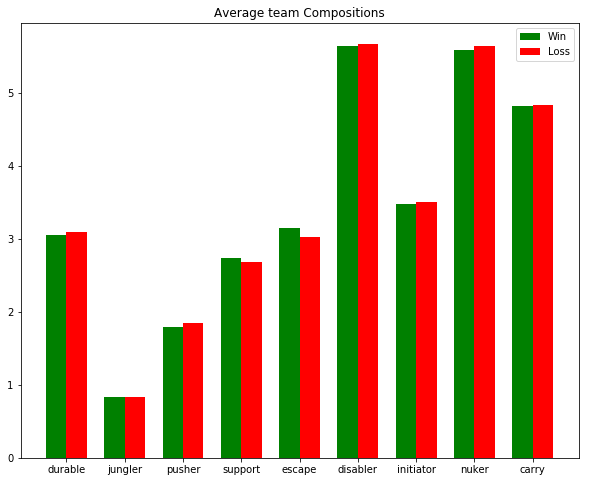

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))

ind = np.arange(len(X))
width = 0.35         # the width of the bars
p1 = ax.bar(ind, Y1, width, color='g')
p2 = ax.bar(ind + width, Y2, width, color='r')

ax.set_title('Average team Compositions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(X)

ax.legend((p1[0], p2[0]), ('Win', 'Loss'))

plt.show()

---
Here we notice that both winning and losing sides play VERY similar team compositions on average. There are very small variances but this is likely due to the random nature of the dataset. Since people tend to play similar teams, then this must mean that people generally have an idea on how to draft heroes. Yet, what would explain why some picks are better than others? A hypothesis that comes to mind is that there exists different kinda of teams as stated in previous sections. Therefore by classifying those teams, we might be able to figure out if certain matchups are more favorable than others.

## 7.2 Most Picked Winning Roles
We resume the conquest for finding hidden information in the set. Perhaps a key distinguishing features between winning and losing lies in which kind of hero is mostly drafted. The objective is to organize a list of hero roles in descending order by the winning and losing teams. From this, we can create a set and observe the differences.

In [57]:
from collections import Counter

winning_roles = []
losing_roles = []

# obtain all the hero roles sorted by win vs lost
for i in range(5):
    winning_roles += training_df[training_df['r_win'] == True]['r_score_' + str(i)].tolist()
    winning_roles += training_df[training_df['r_win'] == True]['d_score_' + str(i)].tolist()
    
    losing_roles += training_df[training_df['r_win'] == False]['r_score_' + str(i)].tolist()
    losing_roles += training_df[training_df['r_win'] == False]['d_score_' + str(i)].tolist()

# obtain sets of most popular 20% roles for winning and losing
winning_roles = sorted(Counter(winning_roles).items(), key=lambda x: x[1], reverse=True)
number_of_roles = len(winning_roles)
winning_roles = set([x[0] for x in winning_roles[:int(0.2*number_of_roles)]])
losing_roles = sorted(Counter(losing_roles).items(), key=lambda x: x[1], reverse=True)
losing_roles = set([x[0] for x in losing_roles[:int(0.2*number_of_roles)]])

# performing set difference
win_diff = winning_roles.difference(losing_roles)
lose_diff = losing_roles.difference(winning_roles)
    
roles = list(role_bits['role'].keys())
roles.reverse()

# obtaining the roles by integer
win_role = win_diff.pop()
lose_role = lose_diff.pop()

# converting roles to their binary format
win_diff = list(bin(win_role)[2:].zfill(9))
lose_diff = list(bin(lose_role)[2:].zfill(9))

# obtaining the string value for every bit
win_role_description = []
for i in range(len(win_diff)):
    if win_diff[i] == '1':
        win_role_description.append(roles[i])

lose_role_description = []
for i in range(len(lose_diff)):
    if lose_diff[i] == '1':
        lose_role_description.append(roles[i])

# obtaining the string representation of heroes with given role
hero_df = pd.read_json('data/enriched_heroes.json', orient='records', lines=True)
winning_hero_name = hero_df[hero_df['score'] == win_role]['hero_name'].tolist() 
losing_hero_name = hero_df[hero_df['score'] == lose_role]['hero_name'].tolist()

print('Number of roles: {}'.format(number_of_roles))
print('Hero role picked by winners: {}'.format(win_role_description))
print('Hero name with role: {}'.format(winning_hero_name))
print('Hero role picked by losers: {}'.format(lose_role_description))
print('Hero name with role: {}'.format(losing_hero_name))

Number of roles: 73
Hero role picked by winners: ['nuker']
Hero name with role: ['zeus']
Hero role picked by losers: ['escape', 'disabler', 'nuker', 'carry']
Hero name with role: ['slark']


---
This data means that Zeus if in the 20% most played heroes on the winning side while it is not in the 20% most played heroes on the losing side. The opposite applies to Slark. We can compare their win ratio to make sure this data makes any sense. Furthermore, we notice that there are 73 unique roles which is slightly dissapointing considering it only reduces the hero pool by half.  

This data did not yield the sort of information I would have hoped for. Once again, not only do teams play very similar roles but the abundance of unique roles generate very specific results which is not what was intended here.  

Finally we can verify and see the hero win rates stated above to perhaps gain some further insight on our findings.

In [58]:
zeus_win_ratio = hero_df[hero_df['hero_name'] == 'zeus']['hero_win_ratio'].tolist()
slark_win_ratio = hero_df[hero_df['hero_name'] == 'slark']['hero_win_ratio'].tolist()

print('Zeus win ratio: {}'.format(zeus_win_ratio))
print('Slark win ratio: {}'.format(slark_win_ratio))

Zeus win ratio: [58.8039]
Slark win ratio: [51.7367]


---
It is a little strange that slark has over 51% win ratio even though he is mainly found on losing teams. The metrics found in this section were completely unconclusive and only lead to dead ends.

## 7.3 Game Duration vs Team composition 
We resume the search to find correlations which may permit us to classify different team compositions. I know that different strategies rely on winning late versus early. For this reason, I have decided to compare different teams with the duration of a match.  

The first step is to use PCA technique on the team vectors in order to reduce their dimensionality so that we may visualize them.

In [59]:
from sklearn.decomposition import PCA

df1 = training_df[training_df['r_win'] == True][['radiant_comp_array', 'r_duration']].sort_values('r_duration')
df2 = training_df[training_df['r_win'] == False][['dire_comp_array', 'r_duration']].sort_values('r_duration')
df1 = df1.rename(columns={'radiant_comp_array': 'comp'})
df2 = df2.rename(columns={'dire_comp_array': 'comp'})
df = df1.append(df2)

comp = df['comp'].tolist()
duration = df['r_duration'].tolist()

pca = PCA(n_components=1)
pca.fit(comp)
pca.explained_variance_ratio_

array([0.24250832])

---
We observe a 0.24 variance ratio which isn't too good but to be expected when reducing from 9 to 1 dimension.

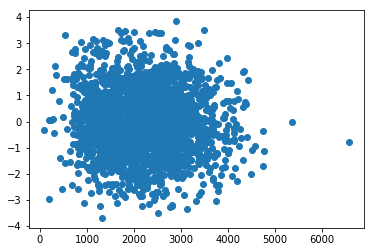

In [60]:
Y = pca.transform(comp)
Y = [x[0] for x in Y]
X = duration

plt.scatter(X, Y)

---
From the figure, there seems to exist almost no correlation between a team composition and the duration of a match... Further investigation into the various roles in a team may provide further insight on what is going on.

In [61]:
carry = [x[8] for x in comp]
nuker = [x[7] for x in comp]
initiator = [x[6] for x in comp]
disabler = [x[5] for x in comp]
escape = [x[4] for x in comp]
support = [x[3] for x in comp]
pusher = [x[2] for x in comp]
jungler = [x[1] for x in comp]
durable = [x[0] for x in comp]
role_dict = {
    'carry': carry, 
    'nuker': nuker, 
    'initiator': initiator, 
    'disabler': disabler, 
    'escape': escape, 
    'support': support, 
    'pusher': pusher, 
    'jungler': jungler, 
    'durable': durable
}

In [63]:
from scipy.stats import linregress
results = {'duration_correlation': {}}
for key in role_dict:
    results['duration_correlation'][key] = linregress(X, role_dict[key])[2]
results

{'duration_correlation': {'carry': -0.0022490999328780197,
  'disabler': 0.055558913483949465,
  'durable': 0.0019861037368211158,
  'escape': 0.019569488491115988,
  'initiator': 0.0483647077953439,
  'jungler': -0.008030207554391974,
  'nuker': 0.024151028090458476,
  'pusher': -0.10392818744406404,
  'support': -0.0029736729327201157}}

---
Once again, this information serves no purpose to us. We have concluded that there exists virtually 0 coefficient of correlation between the roles present in a team versus the duration of a game.

## 7.4 Team Composition vs. Tower Scores
After conducting some small research, people have claimed that pushing teams aim to destroy the opponents towers quickly. So this section, similar to 7.3, will try and find a correlation between the heroes and the tower scores.

In [64]:
df = training_df[training_df['r_win'] == True][['radiant_comp_array', 'r_tower_status', 'd_tower_status']].sort_values('r_tower_status')
r_tower = df['r_tower_status'].tolist()
d_tower = df['d_tower_status'].tolist()
tower = []
for i in range(len(r_tower)):
    tower.append(r_tower[i] - d_tower[i])
df = df.drop(columns=['r_tower_status', 'd_tower_status'])
df['tower_status'] = tower

comp = df['radiant_comp_array'].tolist()
X = df['tower_status'].tolist()

carry = [x[8] for x in comp]
nuker = [x[7] for x in comp]
initiator = [x[6] for x in comp]
disabler = [x[5] for x in comp]
escape = [x[4] for x in comp]
support = [x[3] for x in comp]
pusher = [x[2] for x in comp]
jungler = [x[1] for x in comp]
durable = [x[0] for x in comp]
role_dict = {
    'carry': carry, 
    'nuker': nuker, 
    'initiator': initiator, 
    'disabler': disabler, 
    'escape': escape, 
    'support': support, 
    'pusher': pusher, 
    'jungler': jungler, 
    'durable': durable
}

results['tower_correlation'] = {}
for key in role_dict:
    results['tower_correlation'][key] = linregress(X, role_dict[key])[2]

In [65]:
pd.DataFrame(results).transpose()

,carry,disabler,durable,escape,initiator,jungler,nuker,pusher,support
duration_correlation,-0.002249,0.055559,0.001986,0.019569,0.048365,-0.00803,0.024151,-0.103928,-0.002974
tower_correlation,0.054621,-0.006784,0.006066,-0.014536,-0.053806,-0.02382,0.037321,0.007540,0.000699


---
I cannot believe this. The results are absolutely shocking for someone like me who has played thousands of games. Trying to find hidden correlations in the dataset seems like a waste of time at this point. Ideally it would have been nice to create a heuristic which would help us classify different teams, but to save meaningless effort I have decided to give up on the idea and simply move on to clustering.

# 8. Clustering Team Compositions <a name="clustering"></a>
In this section, we will perform what I consider a last resort since clustering is unsupervised. Because all teams can be represented by vectors, then this process is straight forward.

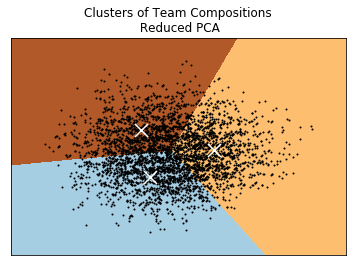

In [66]:
from sklearn.cluster import KMeans
X = training_df['radiant_comp_array'].tolist()
X += training_df['dire_comp_array'].tolist()
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.title('Clusters of Team Compositions\n Reduced PCA')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

---
The above figure isn't really crucial to the development of this process but enables us to visualize the different clusters. The centroids are repesented by the white 'X'. 

Following this, we can perform the actual cluster using all 9 dimensions. Note that I have tried this entire process using 2, 4, 5, 6, and 7 clusters but that 3, as suggested by my research, gave the greatest solution as it will be shown in the machine learning part.

In [67]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.cluster_centers_

array([[1.20306793, 0.39225712, 0.706355  , 2.05332359, 1.30971512,
        3.1687363 , 1.66106647, 3.34989043, 1.81592403],
       [2.28084784, 0.42316427, 0.68887207, 1.01741105, 1.32929599,
        3.2323997 , 2.5321726 , 2.51400454, 2.61619985],
       [1.16119829, 0.43437946, 1.31312411, 0.99714693, 1.97931526,
        2.11911555, 1.09129815, 2.55278174, 2.80599144]])

---
Above are the 3 centroids but they can be clearer to understand when plotted.

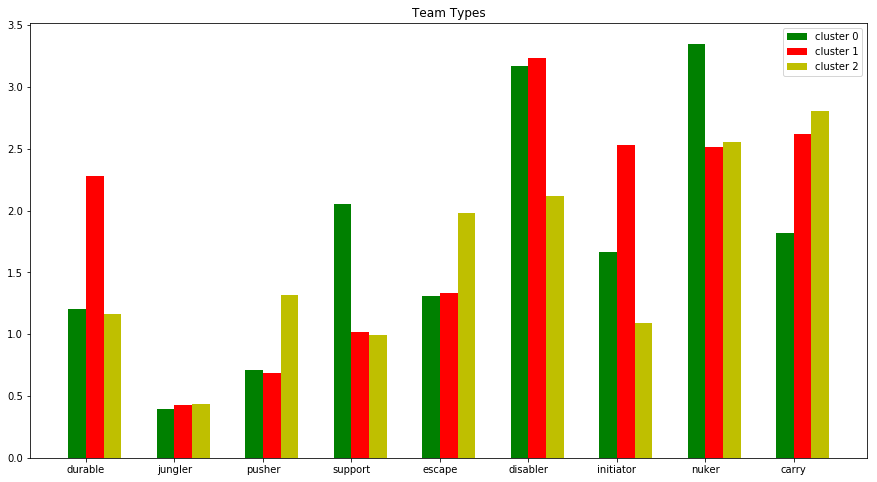

In [68]:
with open('data/role_bits.json') as f:
    role_bits = json.load(f)

X = list(role_bits['role'].keys())
X.reverse()

fig, ax = plt.subplots(figsize=(15, 8))

ind = np.arange(len(X))
width = 0.2         # the width of the bars
p1 = ax.bar(ind, kmeans.cluster_centers_[0], width, color='g')
p2 = ax.bar(ind + width, kmeans.cluster_centers_[1], width, color='r')
p3 = ax.bar(ind + (2 * width), kmeans.cluster_centers_[2], width, color='y')

ax.set_title('Team Types')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(X)

ax.legend((p1[0], p2[0], p3[0]), ('cluster 0', 'cluster 1', 'cluster 2'))

plt.show()

---
This is the first good news in this project yet! The 3 team compositions are quite distinct and actually represent what I would have expected.

## 8.2 Comparing Matchups
If my hypothesis holds true, that certain matchups are indeed favorable then the win/loss ratio should not be 1 to 1. 
1. Gather a list of all wins/loses
2. Classify via clustering
3. Create a tuple (winning strategy, losing strategy)
4. Count how many times X wins over Y

In [69]:
win_list = training_df[training_df['r_win'] == True]['radiant_comp_array'].tolist()
win_list += training_df[training_df['r_win'] == False]['dire_comp_array'].tolist()
win_list = kmeans.predict(win_list)

lose_list = training_df[training_df['r_win'] == False]['radiant_comp_array'].tolist()
lose_list += training_df[training_df['r_win'] == True]['dire_comp_array'].tolist()
lose_list = kmeans.predict(lose_list)

matchup_list = []
for i in range(len(win_list)):
    matchup_list.append((win_list[i], lose_list[i]))

c = Counter(matchup_list)  

---
To make sure the data isn't too biased towards a certain outcome, we visualize the win/loss ratio of the set. The amount of time that the radiant side wins versus the dire side.

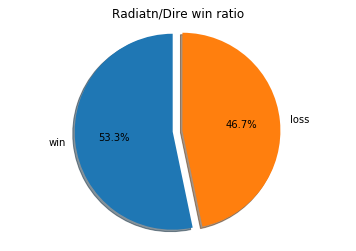

In [71]:
labels = 'win', 'loss'
w_perc = training_df[training_df['r_win'] == True]['r_win'].tolist()
l_perc = training_df[training_df['r_win'] == False]['r_win'].tolist()
sizes = [len(w_perc), len(l_perc)]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Radiatn/Dire win ratio')

plt.show()

---
WOW! We are finding unexpected data in this set. There is a clear bias towards the radiant side and this will surely come into play when attempting predictions. Note that the map isn't quite symmetrical for the dire and radiant teams. This has been a contraversial issue for years within the DOTA community although players accept it for many reasons which do not need to be discussed at the moment.  

Next we will compare all the team compositions once aginast another. I do not know how to label the clusters and therefore only pie charts will be displayed. What we are looking for is biases towards certain compositions.

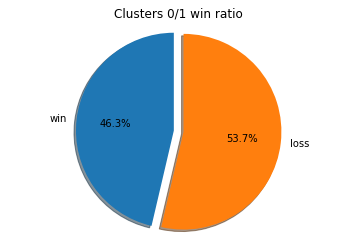

In [74]:
a = c[(0, 1)]
b = c[(1, 0)]

labels = 'win', 'loss'
sizes = [a, b]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Clusters 0/1 win ratio')

plt.show()

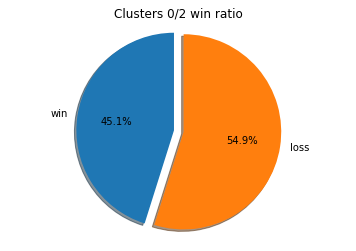

In [75]:
a = c[(0, 2)]
b = c[(2, 0)]

labels = 'win', 'loss'
sizes = [a, b]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Clusters 0/2 win ratio')

plt.show()

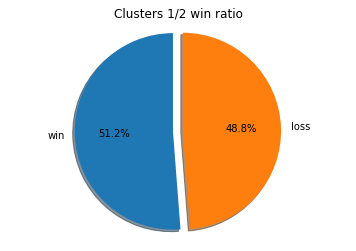

In [76]:
a = c[(1, 2)]
b = c[(2, 1)]

labels = 'win', 'loss'
sizes = [a, b]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Clusters 1/2 win ratio')

plt.show()

---
Excellent. My hypothesis was true and it seems that some matchups are more favorable than some. Therefore this means that we can classify the teams using the kmeans algorithm and then use this classification in our prediction model later on now that we have found a way to simplify the 1X9 vector.

# 9. Refactoring the Training Data <a name="refactor"></a>
This section consists of selected **only** the key features for the machine learning. This means using only the features which would be observable during the drafting phase of the game. Furthermore, we use kmeans to classify team compositions and we add them to the table.  

The features selected are the following:
1. hero win ratio
2. player win ratio with selected hero
3. hero role
4. team composition classification

In [77]:
training_df = pd.read_json('data/training.json', orient='records', lines=True)
df1 = training_df[[
    'r_win_ratio_0',
    'r_win_ratio_1',
    'r_win_ratio_2',
    'r_win_ratio_3',
    'r_win_ratio_4',
    'r_hero_win_ratio_0',
    'r_hero_win_ratio_1',
    'r_hero_win_ratio_2',
    'r_hero_win_ratio_3',
    'r_hero_win_ratio_4',
    'r_score_0',
    'r_score_1',
    'r_score_2',
    'r_score_3',
    'r_score_4',
    'd_win_ratio_0',
    'd_win_ratio_1',
    'd_win_ratio_2',
    'd_win_ratio_3',
    'd_win_ratio_4',
    'd_hero_win_ratio_0',
    'd_hero_win_ratio_1',
    'd_hero_win_ratio_2',
    'd_hero_win_ratio_3',
    'd_hero_win_ratio_4',
    'd_score_0',
    'd_score_1',
    'd_score_2',
    'd_score_3',
    'd_score_4',
    'dire_comp_array',
    'radiant_comp_array'
]]
dire_comp = kmeans.predict(df1['dire_comp_array'].tolist())
radiant_comp = kmeans.predict(df1['radiant_comp_array'].tolist())
df1 = df1.drop(columns=['dire_comp_array', 'radiant_comp_array'])
df1['r_strategy'] = pd.Series(radiant_comp)
df1['d_strategy'] = pd.Series(dire_comp)
df2 = df1.drop(columns=['d_win_ratio_0', 'd_win_ratio_1', 'd_win_ratio_2', 'd_win_ratio_3', 'd_win_ratio_4', 
                        'r_win_ratio_0', 'r_win_ratio_1', 'r_win_ratio_2', 'r_win_ratio_3', 'r_win_ratio_4'])
df1.head()

,r_win_ratio_0,r_win_ratio_1,r_win_ratio_2,r_win_ratio_3,r_win_ratio_4,r_hero_win_ratio_0,r_hero_win_ratio_1,r_hero_win_ratio_2,r_hero_win_ratio_3,r_hero_win_ratio_4,...,d_hero_win_ratio_2,d_hero_win_ratio_3,d_hero_win_ratio_4,d_score_0,d_score_1,d_score_2,d_score_3,d_score_4,r_strategy,d_strategy
0,52.3435,47.8157,52.3403,52.3700,54.7887,52.3435,47.8157,52.3403,52.3700,54.7887,...,45.8225,48.6953,45.1754,62,31,409,329,11,1,1
1,58.8039,54.7365,52.1619,46.0178,44.8759,58.8039,54.7365,52.1619,46.0178,44.8759,...,49.4429,53.5849,50.2133,42,303,59,285,42,2,0
2,50.1249,48.9032,51.6149,52.6203,42.5188,50.1249,48.9032,51.6149,52.6203,42.5188,...,53.5849,55.2318,48.6953,2,67,285,298,329,2,1
3,46.6893,51.7388,50.2902,47.1290,50.1249,46.6893,51.7388,50.2902,47.1290,50.1249,...,53.1906,43.4118,50.3256,302,18,83,11,30,1,0
4,54.0430,47.8157,50.0000,53.6350,46.8351,54.0430,47.8157,50.6204,53.6350,46.8351,...,48.1328,39.1608,55.1602,17,59,46,449,301,2,1


---
Please note that I have made a second dataframe which doesn't use the player win rate with the hero they have selected. After playing around with the machine learning model I have found out concerning those columns. The findings will be explained in the following section.

# 10. Predicting Winning Team <a name="prediction"></a>
Decision trees and gradient boosting are not excellent approaches for this kind of problem since almost every field type is a continuous value. With this being said, the techniques have been tested on this set and yielded terrible results. The data is linearly seperable as Logistic Regression and Support Vector Machines both performed well. Because SVM are harder to setup, I have decided to simply use LR.

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Y = training_df['r_win']
X1 = df1.values.tolist()

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

x_train, x_test, y_train, y_test = train_test_split(X1, Y, test_size=0.10, random_state=42) 
clf = LogisticRegression(C=1e5)
clf.fit(x_train, y_train)

y_predicted = clf.predict(x_test)
accuracy = np.sum(y_predicted == y_test) * 100.0 / len(y_test)
(precision, recall, f1, _) = precision_recall_fscore_support(y_test, y_predicted)

result = {
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'accuracy': accuracy
}
pd.DataFrame(result)

,accuracy,f1,precision,recall
0,60.97561,0.574468,0.580645,0.568421
1,60.97561,0.639640,0.633929,0.645455


---
61% accuracy! Not bad for a game which should be 50/50.  

The next model uses the truncated version of the set without the player win rates with specific heroes. To my great surprise, the model performs even better. I can not explain why.

In [79]:
X2 = df2.values.tolist()

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

x_train, x_test, y_train, y_test = train_test_split(X2, Y, test_size=0.10, random_state=42) 
clf = LogisticRegression(C=1e5)
clf.fit(x_train, y_train)

y_predicted = clf.predict(x_test)
accuracy = np.sum(y_predicted == y_test) * 100.0 / len(y_test)
(precision, recall, f1, _) = precision_recall_fscore_support(y_test, y_predicted)

result = {
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'accuracy': accuracy
}
pd.DataFrame(result)

,accuracy,f1,precision,recall
0,62.926829,0.595745,0.602151,0.589474
1,62.926829,0.657658,0.651786,0.663636


In [80]:
clf.coef_

array([[ 0.1024186 ,  0.15361505,  0.19887481,  0.11069685,  0.19624488,
        -0.02921995, -0.09261493, -0.03322846,  0.05034729,  0.07753146,
        -0.15308884, -0.11632323, -0.09972529, -0.19115308, -0.25263291,
        -0.0895458 ,  0.02264938, -0.06315963, -0.045005  ,  0.02652058,
         0.05259809, -0.08868927]])

--- 
I have printed the weights of every feature in an attempt to perhaps remove some of them. However it seems that all features are within the same order of magnitude and therefore they are all as important as one another. This could mean we have done a good job at selecting the machine learning features as well as a good job at formatting them.

# 11. Conclusion and Findings <a name="conclusion"></a>

1. There already exists standard ways of drafting teams as seen by the similarity by the winning and losing sides.
2. Certain teams establish different chemistries thus giving them different play styles. These playstyles favor certain matchups more than others.
3. A player's win rate with a hero is **not** a good heuristic to evaluate whether they will win or lose.
4. There are no empirical ways to categorize teams.
5. There exists 73 hero roles and 115 heroes. This means that many heroes are unique.
6. It is possible to predict with 63% accuracy, given the extremely finite dataset, which team will win by the end of the drafting phase.
7. Zeus is the oddest pick made by winning teams
8. Slark is the oddest pick made by losing teams
9. Given a larger dataset, it would be able to increase the accuracy of the machine learning model as it has not plateau'd
10. 7.45e+13 ways of drafting heroes